# Technical Analysis Indicator Price Prediction
The goal of this project is to analyze the predictive power of the top 10 most popular TA indicators and see how well they do to predict price over a 30 day period. I am going to find the value of the indicators on day 1 (30 trading days ago) and then find the daily closing price for 30 days later and measure how well the indicator predicted the price.  

first we'll find the top 500 stocks by market cap from nasdaq and pull them into a dataframe


In [50]:
# Warning Supression
import warnings
from pandas.errors import PerformanceWarning 

warnings.filterwarnings('ignore')

warnings.filterwarnings('ignore', category=PerformanceWarning)

# Suppress warnings from yfinance
warnings.filterwarnings("ignore", category=UserWarning, module='yfinance')

# Suppress specific warnings from yfinance
warnings.filterwarnings("ignore", message=".*no price data found.*")


In [51]:
# Importing pandas library for data manipulation and analysis
import pandas as pd

# Load the CSV file into a DataFrame
csv_file_path = '/Users/evancallaghan/Downloads/nasdaq_screener_1726538993372.csv' 
df = pd.read_csv(csv_file_path)


# Filter DataFrame to only show the columns 'Symbol', 'Name', and 'Market Cap'
df = df[['Symbol', 'Name', 'Market Cap']]

# Convert 'Market Cap' to numeric if it's not already
# Remove commas, dollar signs, and replace these symbols with empty spaces
df['Market Cap'] = df['Market Cap'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Sort the DataFrame by Market Cap in descending order
df_sorted = df.sort_values(by='Market Cap', ascending=False).head(1000)                                                                        

# Reset the index of the DataFrame and drop the old index
df_sorted.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_sorted.index = df_sorted.index + 1

# Display the first few rows of the updated DataFrame
df_sorted.head()


,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
4,GOOG,Alphabet Inc. Class C Capital Stock,1.957167e+12
5,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12


In [52]:
# Ensure there are no leading or trailing whitespaces in the 'Name' column
df_sorted['Name'] = df_sorted['Name'].str.strip()

# List of terms to filter out
terms_to_drop = ["Capital Stock", "Depository Shares", "Global Notes", "ADS", 
                 "Registry Shares", "Depositary Shares"
]

# Create a regex pattern to match any of the terms
# //b ensures that the match occues only at the start or end of a word
# pipe '|' ensures that if any of the terms in 'terms_to_drop' are seen, 
# there is a match
pattern = '|'.join([f"\\b{term}\\b" for term in terms_to_drop])

# Apply filtering based on the updated pattern
df_filtered = df_sorted[~df_sorted['Name'].str.contains(pattern, case=False, 
                                                        na=False)
]
# Reset the index of the DataFrame and drop the old index
df_filtered.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_filtered.index = df_filtered.index + 1

# Display the first few rows of the updated DataFrame
df_filtered.head()

,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
4,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12
5,AMZN,Amazon.com Inc. Common Stock,1.940525e+12


In [53]:
# Remove stock tickers not found on yahoo finance
import yfinance as yf
import pandas as pd

# Convert df_filtered['Symbol'] to a list
stock_list = df_filtered['Symbol'].head(50).astype(str).tolist()

# Function to check if a stock ticker is valid
def is_valid_ticker(ticker):
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(period="1d")  # Fetch 1 day of historical data
        return not hist.empty  # Valid if data is not empty
    except Exception as e:
        return False  # If there's an error, consider it invalid


# Filter out invalid tickers
valid_tickers = [ticker for ticker in stock_list if is_valid_ticker(ticker)]

# Keep only valid tickers in df_filtered
df_filtered = df_filtered[df_filtered['Symbol'].isin(valid_tickers)]

# Reset the index of the DataFrame and drop the old index
df_filtered.reset_index(drop=True, inplace=True)

print("All invalid tickers have been successfully removed.")


Failed to get ticker 'BRK/A' reason: Expecting value: line 1 column 1 (char 0)
$BRK/A: possibly delisted; no price data found  (period=1d)
Failed to get ticker 'BRK/B' reason: Expecting value: line 1 column 1 (char 0)
$BRK/B: possibly delisted; no price data found  (period=1d)


All invalid tickers have been successfully removed.


In [54]:
# Keep this one, this is how i got the yahoo data, easier and works faster

import yfinance as yf
import pandas as pd

# Convert df_filtered['Symbol'] to a list of top 25 stocks by marketcap
stock_list = df_filtered['Symbol'].head(25).astype(str).tolist()

# Download data for all stocks
data = yf.download(stock_list, start="2015-01-01", end="2025-02-27", auto_adjust=True, actions=False)[['Close', 'Open', 'High', 'Low', 'Volume']]

# Reshape the data: Convert tickers from columns to rows
daily_stock_price = data.stack().reset_index()

# Rename columns for clarity
daily_stock_price.columns = ['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume']

# Display the transformed DataFrame
daily_stock_price.head()


[*********************100%***********************]  25 of 25 completed


,Date,Symbol,Close,Open,Daily_High,Daily_Low,Volume
0,2015-01-02,AAPL,24.320435,24.778681,24.789804,23.879983,212818400
1,2015-01-02,ABBV,43.156204,42.861468,43.490242,42.861468,5086100
2,2015-01-02,AMZN,15.426000,15.629000,15.737500,15.348000,55664000
3,2015-01-02,AVGO,7.628656,7.692679,7.790238,7.555487,13500000
4,2015-01-02,BAC,14.532608,14.605677,14.638153,14.353996,48951100


In [55]:
# Now group by 'Symbol' and reset the index for the entire dataframe
daily_stock_price = daily_stock_price.groupby('Symbol').apply(lambda x: x.reset_index(drop=True))

# Fill down the 'Symbol' column (so it repeats for each stock's data)
daily_stock_price['Symbol'] = daily_stock_price['Symbol'].fillna(method='ffill')

# Reset the index again and drop the existing 'Symbol' index
daily_stock_price = daily_stock_price.reset_index(drop=True)

# Display the first few rows
daily_stock_price.head()


,Date,Symbol,Close,Open,Daily_High,Daily_Low,Volume
0,2015-01-02,AAPL,24.320435,24.778681,24.789804,23.879983,212818400
1,2015-01-05,AAPL,23.635284,24.089082,24.169164,23.448427,257142000
2,2015-01-06,AAPL,23.637510,23.699796,23.897776,23.274916,263188400
3,2015-01-07,AAPL,23.968960,23.846612,24.069062,23.735387,160423600
4,2015-01-08,AAPL,24.889908,24.298192,24.947745,24.180292,237458000


In [56]:
# Make sure Date column is in datetime datatype format
daily_stock_price['Date'] = pd.to_datetime(daily_stock_price['Date'], errors='coerce')


In [57]:
stock_data_1_week = daily_stock_price.copy()
one_week_window = [5, 3, 7]

In [58]:
# Daily Volume MA
for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'Volume_{window}day_avg'] = stock_data_1_week.groupby('Symbol')['Volume'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )

# Daily High Price MA
for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'Daily_High_{window}day_avg'] = stock_data_1_week.groupby('Symbol')['Daily_High'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )   

# Daily Low Price MA
for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'Daily_Low_{window}day_avg'] = stock_data_1_week.groupby('Symbol')['Daily_Low'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )   

# Daily Open Price MA
for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'Open_{window}day_avg'] = stock_data_1_week.groupby('Symbol')['Open'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )


In [59]:
# adust top features before dropping
stock_data_1_week.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume',
       'Volume_5day_avg', 'Volume_3day_avg', 'Volume_7day_avg',
       'Daily_High_5day_avg', 'Daily_High_3day_avg', 'Daily_High_7day_avg',
       'Daily_Low_5day_avg', 'Daily_Low_3day_avg', 'Daily_Low_7day_avg',
       'Open_5day_avg', 'Open_3day_avg', 'Open_7day_avg'],
      dtype='object')

In [60]:
# Exponential Moving Average

for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'EMA_{window}'] = stock_data_1_week.groupby('Symbol')['Close'].transform(
            lambda x: x.shift(1).ewm(span=window, adjust=False).mean()
        )
       


In [61]:
# Simple Moving Average

for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'SMA_{window}'] = stock_data_1_week.groupby('Symbol')['Close'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        )


In [62]:
stock_data_1_week.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume',
       'Volume_5day_avg', 'Volume_3day_avg', 'Volume_7day_avg',
       'Daily_High_5day_avg', 'Daily_High_3day_avg', 'Daily_High_7day_avg',
       'Daily_Low_5day_avg', 'Daily_Low_3day_avg', 'Daily_Low_7day_avg',
       'Open_5day_avg', 'Open_3day_avg', 'Open_7day_avg', 'EMA_5', 'EMA_3',
       'EMA_7', 'SMA_5', 'SMA_3', 'SMA_7'],
      dtype='object')

In [63]:
# RSI

# Define a function to calculate RSI
def calculate_rsi(stock_data_1_week, window):
    # Calculate price changes
    delta = stock_data_1_week['Close'].diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the rolling average of gains and losses
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    stock_data_1_week['RSI'] = rsi

    return rsi

stock_data_1_week['RSI'] = calculate_rsi(stock_data_1_week, 14).shift(1)

for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'RSI_{window}'] = stock_data_1_week.groupby('Symbol', group_keys=False).apply(
        lambda x: calculate_rsi(x, window=window).shift(1)
        ).reset_index(drop=True)



In [64]:
# MACD

def calculate_macd(df):
    
    df['EMA_12_MACD'] = df.groupby('Symbol')['Close'].transform(
        lambda x: x.ewm(span=12, adjust=False).mean()
    )
    df['EMA_26_MACD'] = df.groupby('Symbol')['Close'].transform(
        lambda x: x.ewm(span=26, adjust=False).mean()
    )

    df['MACD'] = df['EMA_12_MACD'] - df['EMA_26_MACD']
    df['Signal_Line'] = df.groupby('Symbol')['MACD'].transform(
        lambda x: x.ewm(span=9, adjust=False).mean()
    )
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']

    df.drop(columns = ['EMA_12_MACD', 'EMA_26_MACD'], inplace=True)

  

def calculate_rolling_macd(df, window):
    # Apply rolling average to the MACD, Signal Line, and MACD Histogram with a shift to avoid future data leakage
    df[f'MACD_rolling_{window}'] = df.groupby('Symbol')['MACD'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    
    df[f'Signal_rolling_{window}'] = df.groupby('Symbol')['Signal_Line'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    
    df[f'MACD_Histogram_rolling_{window}'] = df.groupby('Symbol')['MACD_Histogram'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    
  

calculate_macd(stock_data_1_week)

for col in stock_data_1_week.columns:
    for window in one_week_window:
        calculate_rolling_macd(stock_data_1_week, window)







In [65]:
stock_data_1_week.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume',
       'Volume_5day_avg', 'Volume_3day_avg', 'Volume_7day_avg',
       'Daily_High_5day_avg', 'Daily_High_3day_avg', 'Daily_High_7day_avg',
       'Daily_Low_5day_avg', 'Daily_Low_3day_avg', 'Daily_Low_7day_avg',
       'Open_5day_avg', 'Open_3day_avg', 'Open_7day_avg', 'EMA_5', 'EMA_3',
       'EMA_7', 'SMA_5', 'SMA_3', 'SMA_7', 'RSI', 'RSI_5', 'RSI_3', 'RSI_7',
       'MACD', 'Signal_Line', 'MACD_Histogram', 'MACD_rolling_5',
       'Signal_rolling_5', 'MACD_Histogram_rolling_5', 'MACD_rolling_3',
       'Signal_rolling_3', 'MACD_Histogram_rolling_3', 'MACD_rolling_7',
       'Signal_rolling_7', 'MACD_Histogram_rolling_7'],
      dtype='object')

In [66]:
# stochastic oscillator
def calculate_stoch_oscillator(df, windows):
        
    df['Stoch_Lowest_Low'] = df.groupby('Symbol')['Daily_Low'].transform(
        lambda x: x.rolling(window=window, min_periods=1).min()
    )
    
    df['Stoch_Highest_High'] = df.groupby('Symbol')['Daily_High'].transform(
        lambda x: x.rolling(window=window, min_periods=1).max()
    )
    
    df[f'%K_{window}'] = ((df['Close'] - df['Stoch_Lowest_Low']) / (df['Stoch_Highest_High'] - df['Stoch_Lowest_Low'])) * 100

    df[f'%D_{window}'] = df.groupby('Symbol')[f'%K_{window}'].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean().shift(1)
    )

    df.drop(columns=['Stoch_Lowest_Low', 'Stoch_Highest_High'], inplace=True)

 
    

def standard_stoch_oscillator(df):
    df['Stoch_Lowest_Low'] = df.groupby('Symbol')['Daily_Low'].transform(
        lambda x: x.rolling(window=14, min_periods=1).min()
    )
    
    df['Stoch_Highest_High'] = df.groupby('Symbol')['Daily_High'].transform(
        lambda x: x.rolling(window=14, min_periods=1).max()
    )
    
    df['%K'] = ((df['Close'] - df['Stoch_Lowest_Low']) / (df['Stoch_Highest_High'] - df['Stoch_Lowest_Low'])) * 100

    df['%D'] = df.groupby('Symbol')['%K'].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
    )

    df.drop(columns=['Stoch_Lowest_Low', 'Stoch_Highest_High'], inplace=True)
  


standard_stoch_oscillator(stock_data_1_week)

for col in stock_data_1_week.columns:  
    for window in one_week_window:
        calculate_stoch_oscillator(stock_data_1_week, window)

    


In [67]:
# VWAP

# Calculate Volume Weighted Average Price (VWAP) per symbol
def calculate_vwap(df):
    # Ensure 'Close' and 'Volume' are numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

    # Calculate cumulative price-volume product for VWAP
    df['Cumulative_Price_Volume'] = df.groupby('Symbol')['Close'].transform(
    lambda x: (x * df.loc[x.index, 'Volume']).cumsum()
    )
    # Calculate cumulative volume for VWAP
    df['Cumulative_Volume'] = df.groupby('Symbol')['Volume'].transform(
    lambda x: x.cumsum()
    )
    # Calculate VWAP as the ratio of cumulative sums for each group (symbol)
    df['VWAP'] = df['Cumulative_Price_Volume'] / df['Cumulative_Volume']



# Add VWAP and VWAP window averages to dataframes
    
calculate_vwap(stock_data_1_week)
for col in stock_data_1_week.columns:

    for window in one_week_window:

        stock_data_1_week[f'VWAP_{window}'] = stock_data_1_week.groupby('Symbol')['VWAP'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )

        

stock_data_1_week.drop(columns=['Cumulative_Price_Volume', 'Cumulative_Volume'], inplace=True)
    

In [68]:
stock_data_1_week.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume',
       'Volume_5day_avg', 'Volume_3day_avg', 'Volume_7day_avg',
       'Daily_High_5day_avg', 'Daily_High_3day_avg', 'Daily_High_7day_avg',
       'Daily_Low_5day_avg', 'Daily_Low_3day_avg', 'Daily_Low_7day_avg',
       'Open_5day_avg', 'Open_3day_avg', 'Open_7day_avg', 'EMA_5', 'EMA_3',
       'EMA_7', 'SMA_5', 'SMA_3', 'SMA_7', 'RSI', 'RSI_5', 'RSI_3', 'RSI_7',
       'MACD', 'Signal_Line', 'MACD_Histogram', 'MACD_rolling_5',
       'Signal_rolling_5', 'MACD_Histogram_rolling_5', 'MACD_rolling_3',
       'Signal_rolling_3', 'MACD_Histogram_rolling_3', 'MACD_rolling_7',
       'Signal_rolling_7', 'MACD_Histogram_rolling_7', '%K', '%D', '%K_5',
       '%D_5', '%K_3', '%D_3', '%K_7', '%D_7', 'VWAP', 'VWAP_5', 'VWAP_3',
       'VWAP_7'],
      dtype='object')

In [69]:
# Calculate Bollinger Bands per symbol

def calculate_bollinger_bands(df):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    df['Middle_Band'] = df.groupby('Symbol')['Close'].transform(
    lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
    )
    
    df['Std_Dev'] = df.groupby('Symbol')['Close'].transform(
    lambda x: x.rolling(window=window, min_periods=1).std().shift(1)
    )
    
    df['Upper_Band'] = df['Middle_Band'] + (df['Std_Dev'] * 2)
    df['Lower_Band'] = df['Middle_Band'] - (df['Std_Dev'] * 2)



def calculate_bollinger_band_windows(df, windows):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    for window in windows:
        df[f'Middle_Band_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )

        df[f'Std_Dev_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std().shift(1)
        )

        df[f'Upper_Band_{window}'] = df[f'Middle_Band_{window}'] + (df[f'Std_Dev_{window}'] * 2)
        df[f'Lower_Band_{window}'] = df[f'Middle_Band_{window}'] - (df[f'Std_Dev_{window}'] * 2)
   


# Add Bollinger Bands to all dataframes

calculate_bollinger_bands(stock_data_1_week)   
for col in stock_data_1_week.columns:
    calculate_bollinger_band_windows(stock_data_1_week, one_week_window)
            


In [70]:
# Average True Range (ATR)

# Function to calculate True Range (TR)
def calculate_true_range(df):
    # Convert relevant columns to numeric (if not already numeric)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Daily_High'] = pd.to_numeric(df['Daily_High'], errors='coerce')
    df['Daily_Low'] = pd.to_numeric(df['Daily_Low'], errors='coerce')

    # Ensure previous close is calculated per stock symbol to prevent cross-stock contamination
    df['ATR_Prev_Close'] = df.groupby('Symbol')['Close'].shift(1)

    df['ATR_High_Low'] = df['Daily_High'] - df['Daily_Low']  # High - Low
    df['ATR_High_Close'] = (df['Daily_High'] - df['ATR_Prev_Close']).abs()  # High - Prev Close
    df['ATR_Low_Close'] = (df['Daily_Low'] - df['ATR_Prev_Close']).abs()  # Low - Prev Close

    # True Range is the max of the three
    df['ATR'] = df[['ATR_High_Low', 'ATR_High_Close', 'ATR_Low_Close']].max(axis=1)

    df.drop(columns=['ATR_Prev_Close', 'ATR_High_Low', 'ATR_High_Close', 'ATR_Low_Close'], inplace=True)
    


calculate_true_range(stock_data_1_week)

# Add ATR calculation to all dataframes and add rolling windows
for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'ATR_{window}'] = stock_data_1_week.groupby('Symbol')['ATR'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )

In [71]:
stock_data_1_week.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume',
       'Volume_5day_avg', 'Volume_3day_avg', 'Volume_7day_avg',
       'Daily_High_5day_avg', 'Daily_High_3day_avg', 'Daily_High_7day_avg',
       'Daily_Low_5day_avg', 'Daily_Low_3day_avg', 'Daily_Low_7day_avg',
       'Open_5day_avg', 'Open_3day_avg', 'Open_7day_avg', 'EMA_5', 'EMA_3',
       'EMA_7', 'SMA_5', 'SMA_3', 'SMA_7', 'RSI', 'RSI_5', 'RSI_3', 'RSI_7',
       'MACD', 'Signal_Line', 'MACD_Histogram', 'MACD_rolling_5',
       'Signal_rolling_5', 'MACD_Histogram_rolling_5', 'MACD_rolling_3',
       'Signal_rolling_3', 'MACD_Histogram_rolling_3', 'MACD_rolling_7',
       'Signal_rolling_7', 'MACD_Histogram_rolling_7', '%K', '%D', '%K_5',
       '%D_5', '%K_3', '%D_3', '%K_7', '%D_7', 'VWAP', 'VWAP_5', 'VWAP_3',
       'VWAP_7', 'Middle_Band', 'Std_Dev', 'Upper_Band', 'Lower_Band',
       'Middle_Band_5', 'Std_Dev_5', 'Upper_Band_5', 'Lower_Band_5',
       'Middle_Band_3', 'Std_Dev_3', 'Upper_Band_3', 

In [72]:
import numpy as np
import pandas as pd

# Group by 'Symbol' and calculate Fibonacci levels for a given window
def fib_retracement(df, windows, levels):
    for window in windows:
        # Calculate rolling max and min for each window
        df[f'Fib_{window}_High_Max'] = df.groupby('Symbol')['Daily_High'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).max()
        )
        df[f'Fib_{window}_Low_Min'] = df.groupby('Symbol')['Daily_Low'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).min()
        )
    
        # Calculate Fibonacci retracement levels for each level
        for level in fib_levels:
            df[f'{window}_day_Fib_{level*100:.1f}%'] = df[f'Fib_{window}_High_Max'] - (
                level * (df[f'Fib_{window}_High_Max'] - df[f'Fib_{window}_Low_Min']))
        df.drop(columns = [f'Fib_{window}_High_Max', f'Fib_{window}_Low_Min'], inplace=True)
    



# Define Fibonacci levels
fib_levels = [0.236, 0.382, 0.500, 0.618, 0.786, 1.000, 1.618, 2.618, 4.236]
# fib_windows = [5, 14, 30]

fib_retracement(stock_data_1_week, one_week_window, fib_levels)


In [73]:
# OBV

def calculate_obv(df):
    df['OBV'] = df.groupby('Symbol').apply(
        lambda group: (np.sign(group['Close'].diff()) * group['Volume']).cumsum()
    ).reset_index(level=0, drop=True)

    df['OBV'] = df['OBV'].shift(1)
    
    df['OBV'] = df['OBV'].fillna(0) 

    return df

def calculate_rolling_obv(df, windows):
    df[f'OBV_{window}day_avg'] = df.groupby('Symbol')['OBV'].transform(
        lambda x: x.rolling(window=window).mean()
    )

    df[f'OBV_{window}day_avg'] = df[f'OBV_{window}day_avg'].fillna(0)
    


calculate_obv(stock_data_1_week)

for col in stock_data_1_week.columns:
    for window in one_week_window:
        calculate_rolling_obv(stock_data_1_week, window)


In [74]:
stock_data_1_week.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume',
       'Volume_5day_avg', 'Volume_3day_avg', 'Volume_7day_avg',
       ...
       '7_day_Fib_61.8%', '7_day_Fib_78.6%', '7_day_Fib_100.0%',
       '7_day_Fib_161.8%', '7_day_Fib_261.8%', '7_day_Fib_423.6%', 'OBV',
       'OBV_5day_avg', 'OBV_3day_avg', 'OBV_7day_avg'],
      dtype='object', length=104)

In [75]:
# Momentum Features

def calculate_momentum(df, windows):
    for window in windows:

        df[f'Momentum_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x - x.shift(window)
        ).fillna(0)


calculate_momentum(stock_data_1_week, one_week_window)



In [76]:
# Quantile-Based Features

def calculate_quantiles(df, windows):

    for window in windows:
    
        df[f'Rolling_Median_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.shift(1).rolling(window=window).median()
        ).fillna(0)
    
        # Rolling 25th Quantile
        df[f'Rolling_Quantile_25_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.shift(1).rolling(window=window).quantile(0.25)
        ).fillna(0)
    
        # Rolling 75th Quantile
        df[f'Rolling_Quantile_75_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.shift(1).rolling(window=window).quantile(0.75)
        ).fillna(0)


calculate_quantiles(stock_data_1_week, one_week_window)


In [77]:
stock_data_1_week.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume',
       'Volume_5day_avg', 'Volume_3day_avg', 'Volume_7day_avg',
       ...
       'Momentum_7', 'Rolling_Median_5', 'Rolling_Quantile_25_5',
       'Rolling_Quantile_75_5', 'Rolling_Median_3', 'Rolling_Quantile_25_3',
       'Rolling_Quantile_75_3', 'Rolling_Median_7', 'Rolling_Quantile_25_7',
       'Rolling_Quantile_75_7'],
      dtype='object', length=116)

In [78]:
# get top 50 important features

from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import xgboost as xgb


# Initialize dictionary to keep track of feature importance as we add more features
# After adding our final features, we will remove any features that have less than 
# a 1% feature importance total

stock_data_important_feat = stock_data_1_week.copy()

# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_important_feat = stock_data_important_feat.sort_values(by=['Symbol', 'Date'])

# Train on all data before 2023-01-24, test all data after 2023-01-31
stock_data_train = stock_data_important_feat[stock_data_important_feat['Date'] <= '2023-01-24']
stock_data_test = stock_data_important_feat[stock_data_important_feat['Date'] > '2023-01-31']

# Check if the test set is empty
#if stock_data_test.empty:
    #raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train['Close_Target'] = stock_data_train.groupby('Symbol')['Close'].shift(-5)
stock_data_test['Close_Target'] = stock_data_test.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train = stock_data_train.dropna(subset=['Close_Target'])
stock_data_test = stock_data_test.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test.select_dtypes(include=[np.number]).columns

stock_data_train[numeric_cols_train] = stock_data_train[numeric_cols_train].fillna(stock_data_train[numeric_cols_train].median())
stock_data_test[numeric_cols_test] = stock_data_test[numeric_cols_test].fillna(stock_data_test[numeric_cols_test].median())

# Create X (features) and y (target) for training
X_train = stock_data_train.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train = stock_data_train['Close_Target']

# Create X and y for testing
X_test = stock_data_test.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test = stock_data_test['Close_Target']

# Ensure there are samples in both training and testing sets
# if X_train.shape[0] == 0 or X_test.shape[0] == 0:
#     raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan, # Ensure missing values are handled correctly
    random_state=42
)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions 
y_pred_ = model.predict(X_test)

# not doinng this anymore, instead we are getting list of top 20 important features
# and using that instead, may change it to top 30 if we see noticible improvement

# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)

# Sort by importance and select top 10
top_50_important_features = feature_importance.nlargest(50).index.tolist()
print("Top 50 Important Features:", top_50_important_features)


Top 50 Important Features: ['Daily_Low', 'Rolling_Quantile_25_3', 'Daily_High', '5_day_Fib_50.0%', '3_day_Fib_50.0%', '3_day_Fib_78.6%', '7_day_Fib_78.6%', '5_day_Fib_23.6%', 'Open_5day_avg', '5_day_Fib_100.0%', 'EMA_5', 'SMA_5', '7_day_Fib_23.6%', '7_day_Fib_38.2%', 'Upper_Band', 'Rolling_Quantile_25_7', 'Rolling_Median_7', 'Rolling_Quantile_75_5', 'Upper_Band_5', 'EMA_7', 'SMA_7', 'Open', 'Rolling_Quantile_75_3', '5_day_Fib_61.8%', 'Rolling_Quantile_75_7', 'Daily_High_7day_avg', 'Lower_Band_3', 'Open_7day_avg', 'Rolling_Quantile_25_5', '5_day_Fib_78.6%', '3_day_Fib_261.8%', '7_day_Fib_61.8%', 'Daily_High_5day_avg', 'Rolling_Median_5', 'Daily_Low_3day_avg', 'Upper_Band_3', 'Lower_Band_5', '3_day_Fib_161.8%', '7_day_Fib_261.8%', 'Daily_Low_5day_avg', '7_day_Fib_100.0%', '7_day_Fib_161.8%', '3_day_Fib_61.8%', '3_day_Fib_100.0%', '3_day_Fib_38.2%', 'Daily_Low_7day_avg', 'Daily_High_3day_avg', '5_day_Fib_161.8%', '3_day_Fib_23.6%', '5_day_Fib_261.8%']


In [79]:
stock_data_1_week.shape

(63825, 116)

In [80]:
# Add lags to the first 20 features in the top 50 most important
features_to_lag = top_50_important_features[:20]

# Creating lag features for each column
lags = [1, 2, 3, 4, 5]

def calculate_lag(df, features, lags):
    # Apply lags to the dataframe
    for col in features:
        if col in df.columns:
            for lag in lags:
                if f'{col}_lag_{lag}' not in df.columns:
                    df[f'{col}_lag_{lag}'] = df[col].shift(lag)
            # else:
                # print(f"Column '{col}' not found in dataframe, skipping.")


# Assuming stock_dataframes is a list of your dataframes

calculate_lag(stock_data_1_week, features_to_lag, lags)
    
stock_data_1_week.shape

(63825, 216)

In [81]:
# with the addition of the first 20 features lagged, we get top 50 important features again
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import xgboost as xgb


# Initialize dictionary to keep track of feature importance as we add more features
# After adding our final features, we will remove any features that have less than 
# a 1% feature importance total

stock_data_important_feat = stock_data_1_week.copy()

# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_important_feat = stock_data_important_feat.sort_values(by=['Symbol', 'Date'])

# Train on all data before 2023-01-24, test all data after 2023-01-31
stock_data_train = stock_data_important_feat[stock_data_important_feat['Date'] <= '2023-01-24']
stock_data_test = stock_data_important_feat[stock_data_important_feat['Date'] > '2023-01-31']

# Check if the test set is empty
#if stock_data_test.empty:
    #raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train['Close_Target'] = stock_data_train.groupby('Symbol')['Close'].shift(-5)
stock_data_test['Close_Target'] = stock_data_test.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train = stock_data_train.dropna(subset=['Close_Target'])
stock_data_test = stock_data_test.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test.select_dtypes(include=[np.number]).columns

stock_data_train[numeric_cols_train] = stock_data_train[numeric_cols_train].fillna(stock_data_train[numeric_cols_train].median())
stock_data_test[numeric_cols_test] = stock_data_test[numeric_cols_test].fillna(stock_data_test[numeric_cols_test].median())

# Create X (features) and y (target) for training
X_train = stock_data_train.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train = stock_data_train['Close_Target']

# Create X and y for testing
X_test = stock_data_test.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test = stock_data_test['Close_Target']

# Ensure there are samples in both training and testing sets
# if X_train.shape[0] == 0 or X_test.shape[0] == 0:
#     raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan, # Ensure missing values are handled correctly
    random_state=42
)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions 
y_pred_ = model.predict(X_test)

# not doinng this anymore, instead we are getting list of top 20 important features
# and using that instead, may change it to top 30 if we see noticible improvement

# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)

# Sort by importance and select top 50
top_50_important_features = feature_importance.nlargest(50).index.tolist()
print("Top 50 Important Features:", top_50_important_features)


Top 50 Important Features: ['Daily_Low', '3_day_Fib_61.8%', '5_day_Fib_50.0%', 'Daily_High', 'Rolling_Quantile_25_3', 'Daily_Low_lag_3', 'SMA_5_lag_5', '3_day_Fib_50.0%_lag_5', '3_day_Fib_78.6%', 'Daily_Low_lag_5', '3_day_Fib_50.0%', 'EMA_5', '3_day_Fib_50.0%_lag_1', '7_day_Fib_23.6%', 'Daily_Low_lag_1', 'Upper_Band', '5_day_Fib_23.6%', 'Rolling_Quantile_75_5', 'Rolling_Quantile_25_7', '7_day_Fib_38.2%', '5_day_Fib_100.0%', 'Upper_Band_5', '5_day_Fib_61.8%', 'Open_5day_avg', 'Daily_High_7day_avg', 'Rolling_Quantile_75_7', 'SMA_7', '5_day_Fib_100.0%_lag_4', 'EMA_7', 'Rolling_Quantile_75_3', 'Open', 'Lower_Band_3', 'Daily_High_5day_avg', '7_day_Fib_38.2%_lag_2', 'Daily_Low_3day_avg', 'Open_7day_avg', '7_day_Fib_61.8%', '3_day_Fib_261.8%', '7_day_Fib_23.6%_lag_1', 'Rolling_Quantile_25_5', 'SMA_5', '5_day_Fib_100.0%_lag_5', 'EMA_5_lag_5', 'Daily_High_lag_2', '7_day_Fib_78.6%', '7_day_Fib_161.8%', '7_day_Fib_100.0%', 'Upper_Band_3', 'Lower_Band_5', 'Daily_High_lag_1']


In [82]:
descriptive_features = ['Symbol', 'Date']

target_feature = ['Close']

filtered_features = descriptive_features + target_feature + top_50_important_features

stock_data_1_week = stock_data_1_week[filtered_features]

In [83]:
stock_data_1_week.shape

(63825, 53)

In [84]:

features_to_lag = target_feature

# Creating lag features for each column
lags = [1, 2, 3, 4, 5]

def calculate_lag(df, features, lags):
    # Apply lags to the dataframe
    for col in features:
        if col in df.columns:
            for lag in lags:
                if f'{col}_lag_{lag}' not in df.columns:
                    df[f'{col}_lag_{lag}'] = df[col].shift(lag)
            # else:
                # print(f"Column '{col}' not found in dataframe, skipping.")


# Assuming stock_dataframes is a list of your dataframes

calculate_lag(stock_data_1_week, features_to_lag, lags)
    
stock_data_1_week.head()

,Symbol,Date,Close,Daily_Low,3_day_Fib_61.8%,5_day_Fib_50.0%,Daily_High,Rolling_Quantile_25_3,Daily_Low_lag_3,SMA_5_lag_5,...,7_day_Fib_161.8%,7_day_Fib_100.0%,Upper_Band_3,Lower_Band_5,Daily_High_lag_1,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5
0,AAPL,2015-01-02,24.320435,23.879983,NaN,NaN,24.789804,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2015-01-05,23.635284,23.448427,24.227535,24.334894,24.169164,0.000000,NaN,NaN,...,23.317714,23.879983,NaN,NaN,24.789804,24.320435,NaN,NaN,NaN,NaN
2,AAPL,2015-01-06,23.637510,23.274916,23.960833,24.119116,23.897776,0.000000,NaN,NaN,...,22.619457,23.448427,24.946808,23.008911,24.169164,23.635284,24.320435,NaN,NaN,NaN
3,AAPL,2015-01-07,23.968960,23.735387,23.853603,24.032360,24.069062,23.636397,23.879983,NaN,...,22.338716,23.274916,24.654271,23.074548,23.897776,23.637510,23.635284,24.320435,NaN,NaN
4,AAPL,2015-01-08,24.889908,24.180292,23.616519,24.032360,24.947745,23.636397,23.448427,NaN,...,22.338716,23.274916,24.131268,23.237209,24.069062,23.968960,23.637510,23.635284,24.320435,NaN


In [85]:
stock_data_1_week.shape

(63825, 58)

# BASELINE MODEL

In [94]:
# model 1: BASELINE MODEL

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_baseline = stock_data_1_week[stock_data_1_week['Date'] <= '2023-01-24']

# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_baseline = stock_data_1_week[stock_data_1_week['Date'] > '2023-01-31']


# Check if the test set is empty
if stock_data_test_1_week_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_baseline['Close_Target'] = stock_data_train_1_week_baseline.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_baseline['Close_Target'] = stock_data_test_1_week_baseline.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_baseline = stock_data_train_1_week_baseline.dropna(subset=['Close_Target'])
stock_data_test_1_week_baseline = stock_data_test_1_week_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_baseline.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_baseline[numeric_cols_train] = stock_data_train_1_week_baseline[numeric_cols_train].fillna(stock_data_train_1_week_baseline[numeric_cols_train].median())
stock_data_test_1_week_baseline[numeric_cols_test] = stock_data_test_1_week_baseline[numeric_cols_test].fillna(stock_data_test_1_week_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_baseline.shape}")
print(f"Testing data shape: {stock_data_test_1_week_baseline.shape}")

# Create X (features) and y (target) for training
X_train_1_week_baseline = stock_data_train_1_week_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_baseline = stock_data_train_1_week_baseline['Close_Target']

# Create X and y for testing
X_test_1_week_baseline = stock_data_test_1_week_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_baseline = stock_data_test_1_week_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_baseline shape: {X_train_1_week_baseline.shape}, y_train_1_week_baseline shape: {y_train_1_week_baseline.shape}")
print(f"X_test_1_week_baseline shape: {X_test_1_week_baseline.shape}, y_test_1_week_baseline shape: {y_test_1_week_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_baseline.shape[0] == 0 or X_test_1_week_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_week = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan,  # Ensure missing values are handled correctly
    colsample_bytree = 1,
    random_state=42
)

# Train the model on the training data
model_baseline_1_week.fit(X_train_1_week_baseline, y_train_1_week_baseline)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_baseline = model_baseline_1_week.predict(X_test_1_week_baseline)

# Calculate performance on the test data
mse_test_1_week_baseline = mean_squared_error(y_test_1_week_baseline, y_pred_1_week_baseline)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_baseline}')


Training data shape: (50600, 59)
Testing data shape: (12850, 59)
X_train_1_week_baseline shape: (50600, 55), y_train_1_week_baseline shape: (50600,)
X_test_1_week_baseline shape: (12850, 55), y_test_1_week_baseline shape: (12850,)
Mean Squared Error on unseen data (post-February 17, 2024): 4761.313976329626


In [95]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_baseline` are your predictions for the test data and `y_test_1_week_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_baseline = mean_squared_error(y_test_1_week_baseline, y_pred_1_week_baseline)
mae_1_week_baseline = mean_absolute_error(y_test_1_week_baseline, y_pred_1_week_baseline)
rmse_1_week_baseline = np.sqrt(mse_1_week_baseline)  # Root Mean Squared Error
r2_1_week_baseline = r2_score(y_test_1_week_baseline, y_pred_1_week_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_baseline}')
print(f'R-squared on unseen data: {r2_1_week_baseline}')

# Additional metrics
medae_1_week_baseline = median_absolute_error(y_test_1_week_baseline, y_pred_1_week_baseline)
print(f'Median Absolute Error on unseen data: {medae_1_week_baseline}')

dw_stat_1_week_baseline = durbin_watson(y_test_1_week_baseline - y_pred_1_week_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_baseline = np.mean(np.abs((y_test_1_week_baseline - y_pred_1_week_baseline) / y_test_1_week_baseline)) * 100
print(f'MAPE on unseen data: {mape_1_week_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_baseline = dict(zip(X_train_1_week_baseline.columns, model_baseline_1_week.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_baseline = sorted(feature_importance_1_week_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_baseline:
    # if int(importance*100) >= 1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 4761.313976329626
Mean Absolute Error on unseen data: 21.263672313170673
Root Mean Squared Error on unseen data: 69.00227515328481
R-squared on unseen data: 0.8719243239938792
Median Absolute Error on unseen data: 3.9986801147460938
Durbin-Watson Statistic on unseen data: 0.017295761825052446
MAPE on unseen data: 4.80%
Daily_Low: 54.53%
Daily_High: 22.70%
3_day_Fib_50.0%: 3.22%
Open: 2.59%
Daily_Low_lag_3: 1.56%
3_day_Fib_61.8%: 1.55%
5_day_Fib_50.0%: 1.28%
Daily_Low_lag_5: 1.27%
7_day_Fib_23.6%: 1.15%
5_day_Fib_23.6%: 1.10%
Daily_Low_lag_1: 1.07%
7_day_Fib_38.2%: 0.94%
SMA_5_lag_5: 0.92%
Rolling_Quantile_75_5: 0.72%
3_day_Fib_78.6%: 0.68%
Upper_Band: 0.66%
5_day_Fib_100.0%: 0.50%
Upper_Band_5: 0.42%
Rolling_Quantile_75_3: 0.38%
SMA_7: 0.38%
Rolling_Quantile_25_5: 0.37%
Rolling_Quantile_25_7: 0.19%
Daily_High_7day_avg: 0.19%
3_day_Fib_50.0%_lag_1: 0.15%
EMA_7: 0.15%
5_day_Fib_100.0%_lag_4: 0.14%
Close_lag_5: 0.09%
7_day_Fib_38.2%_lag_2: 0.09%
Daily_Hi

In [114]:
# model 2: colsample_bytree = 0.5
# attempt to reduce feature dominance, increase feature diversity, and prevent overfitting

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_bytree = stock_data_1_week[stock_data_1_week['Date'] <= '2023-01-24']

# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_bytree = stock_data_1_week[stock_data_1_week['Date'] > '2023-01-31']


# Check if the test set is empty
if stock_data_test_1_week_bytree.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_bytree['Close_Target'] = stock_data_train_1_week_bytree.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_bytree['Close_Target'] = stock_data_test_1_week_bytree.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_bytree = stock_data_train_1_week_bytree.dropna(subset=['Close_Target'])
stock_data_test_1_week_bytree = stock_data_test_1_week_bytree.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_bytree.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_bytree.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_bytree.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_bytree.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_bytree[numeric_cols_train] = stock_data_train_1_week_bytree[numeric_cols_train].fillna(stock_data_train_1_week_bytree[numeric_cols_train].median())
stock_data_test_1_week_bytree[numeric_cols_test] = stock_data_test_1_week_bytree[numeric_cols_test].fillna(stock_data_test_1_week_bytree[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_bytree.shape}")
print(f"Testing data shape: {stock_data_test_1_week_bytree.shape}")


# Create X (features) and y (target) for training
X_train_1_week_bytree = stock_data_train_1_week_bytree.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_bytree = stock_data_train_1_week_bytree['Close_Target']

# Create X and y for testing
X_test_1_week_bytree = stock_data_test_1_week_bytree.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_bytree = stock_data_test_1_week_bytree['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_bytree shape: {X_train_1_week_bytree.shape}, y_train_1_week_bytree shape: {y_train_1_week_bytree.shape}")
print(f"X_test_1_week_bytree shape: {X_test_1_week_bytree.shape}, y_test_1_week_bytree shape: {y_test_1_week_bytree.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_bytree.shape[0] == 0 or X_test_1_week_bytree.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_bytree = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan,  # Ensure missing values are handled correctly
    colsample_bytree = 0.5,
    random_state=42
)

# Train the model on the training data
model_1_week_bytree.fit(X_train_1_week_bytree, y_train_1_week_bytree)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_bytree = model_1_week_bytree.predict(X_test_1_week_bytree)

# Calculate performance on the test data
mse_test_1_week_bytree = mean_squared_error(y_test_1_week_bytree, y_pred_1_week_bytree)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_bytree}')


Training data shape: (50600, 59)
Testing data shape: (12850, 59)
X_train_1_week_bytree shape: (50600, 55), y_train_1_week_bytree shape: (50600,)
X_test_1_week_bytree shape: (12850, 55), y_test_1_week_bytree shape: (12850,)
Mean Squared Error on unseen data (post-February 17, 2024): 4756.526415078256


In [115]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_bytree` are your predictions for the test data and `y_test_1_week_bytree` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_bytree = mean_squared_error(y_test_1_week_bytree, y_pred_1_week_bytree)
mae_1_week_bytree = mean_absolute_error(y_test_1_week_bytree, y_pred_1_week_bytree)
rmse_1_week_bytree = np.sqrt(mse_1_week_bytree)  # Root Mean Squared Error
r2_1_week_bytree = r2_score(y_test_1_week_bytree, y_pred_1_week_bytree)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_bytree}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_bytree}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_bytree}')
print(f'R-squared on unseen data: {r2_1_week_bytree}')

# Additional metrics
medae_1_week_bytree = median_absolute_error(y_test_1_week_bytree, y_pred_1_week_bytree)
print(f'Median Absolute Error on unseen data: {medae_1_week_bytree}')

dw_stat_1_week_bytree = durbin_watson(y_test_1_week_bytree - y_pred_1_week_bytree)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_bytree}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_bytree = np.mean(np.abs((y_test_1_week_bytree - y_pred_1_week_bytree) / y_test_1_week_bytree)) * 100
print(f'MAPE on unseen data: {mape_1_week_bytree:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_bytree = dict(zip(X_train_1_week_bytree.columns, model_1_week_bytree.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_bytree = sorted(feature_importance_1_week_bytree.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_bytree:
    # if int(importance*100) >= 1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 4756.526415078256
Mean Absolute Error on unseen data: 21.212369629678097
Root Mean Squared Error on unseen data: 68.96757509930487
R-squared on unseen data: 0.8720531057013529
Median Absolute Error on unseen data: 3.9840240478515625
Durbin-Watson Statistic on unseen data: 0.016772766501028633
MAPE on unseen data: 4.80%
Open: 37.13%
Daily_Low: 27.06%
Daily_High: 16.32%
3_day_Fib_78.6%: 5.46%
5_day_Fib_50.0%: 2.54%
7_day_Fib_38.2%: 1.44%
3_day_Fib_61.8%: 1.07%
Daily_Low_lag_1: 1.04%
Rolling_Quantile_25_7: 1.00%
Daily_Low_lag_3: 0.92%
Daily_Low_lag_5: 0.77%
3_day_Fib_50.0%: 0.73%
Daily_High_lag_1: 0.57%
3_day_Fib_50.0%_lag_5: 0.50%
Rolling_Quantile_25_3: 0.35%
SMA_5_lag_5: 0.32%
7_day_Fib_23.6%: 0.29%
Upper_Band_5: 0.28%
Daily_High_7day_avg: 0.28%
Rolling_Quantile_75_5: 0.22%
Upper_Band: 0.22%
5_day_Fib_23.6%: 0.18%
EMA_5: 0.16%
Rolling_Quantile_75_3: 0.15%
5_day_Fib_100.0%: 0.09%
Close_lag_5: 0.07%
EMA_7: 0.07%
Lower_Band_3: 0.06%
3_day_Fib_261.8%: 0.05

## baseline vs model with colsample_bytree = 0.5
model with colsample_bytree = 0.5 is not only has more feature diversity, but was either stable or had a slight improvement in all metrics

In [124]:
# model 3
# colsample_bytree = 0.5
# now we are adjusting the hyperparameter learnaing_rate
# learning_rate = 0.01

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_lr_01 = stock_data_1_week[stock_data_1_week['Date'] <= '2023-01-24']

# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_lr_01 = stock_data_1_week[stock_data_1_week['Date'] > '2023-01-31']

# Check if the test set is empty
if stock_data_test_1_week_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_lr_01['Close_Target'] = stock_data_train_1_week_lr_01.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_lr_01['Close_Target'] = stock_data_test_1_week_lr_01.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_lr_01 = stock_data_train_1_week_lr_01.dropna(subset=['Close_Target'])
stock_data_test_1_week_lr_01 = stock_data_test_1_week_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_lr_01.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_lr_01[numeric_cols_train] = stock_data_train_1_week_lr_01[numeric_cols_train].fillna(stock_data_train_1_week_lr_01[numeric_cols_train].median())
stock_data_test_1_week_lr_01[numeric_cols_test] = stock_data_test_1_week_lr_01[numeric_cols_test].fillna(stock_data_test_1_week_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_lr_01.shape}")
print(f"Testing data shape: {stock_data_test_1_week_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_1_week_lr_01 = stock_data_train_1_week_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_lr_01 = stock_data_train_1_week_lr_01['Close_Target']

# Create X and y for testing
X_test_1_week_lr_01 = stock_data_test_1_week_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_lr_01 = stock_data_test_1_week_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_lr_01 shape: {X_train_1_week_lr_01.shape}, y_train_1_week_lr_01 shape: {y_train_1_week_lr_01.shape}")
print(f"X_test_1_week_lr_01 shape: {X_test_1_week_lr_01.shape}, y_test_1_week_lr_01 shape: {y_test_1_week_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_lr_01.shape[0] == 0 or X_test_1_week_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_lr_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan,  # Ensure missing values are handled correctly
    colsample_bytree = 0.5,
    random_state=42
)

# Train the model on the training data
model_1_week_lr_01.fit(X_train_1_week_lr_01, y_train_1_week_lr_01)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_lr_01 = model_1_week_lr_01.predict(X_test_1_week_lr_01)

# Calculate performance on the test data
mse_test_1_week_lr_01 = mean_squared_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_lr_01}')


Training data shape: (50600, 59)
Testing data shape: (12850, 59)
X_train_1_week_lr_01 shape: (50600, 55), y_train_1_week_lr_01 shape: (50600,)
X_test_1_week_lr_01 shape: (12850, 55), y_test_1_week_lr_01 shape: (12850,)
Mean Squared Error on unseen data (post-February 17, 2024): 4796.633542432664


In [125]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_week_lr_01` are your predictions for the test data and `y_test_1_week_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_lr_01 = mean_squared_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
mae_1_week_lr_01 = mean_absolute_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
rmse_1_week_lr_01 = np.sqrt(mse_1_week_lr_01)  # Root Mean Squared Error
r2_1_week_lr_01 = r2_score(y_test_1_week_lr_01, y_pred_1_week_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_lr_01}')
print(f'R-squared on unseen data: {r2_1_week_lr_01}')

# Additional metrics
medae_week_lr_01 = median_absolute_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
print(f'Median Absolute Error on unseen data: {medae_week_lr_01}')

dw_stat_1_week_lr_01 = durbin_watson(y_test_1_week_lr_01 - y_pred_1_week_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_lr_01 = np.mean(np.abs((y_test_1_week_lr_01 - y_pred_1_week_lr_01) / y_test_1_week_lr_01)) * 100
print(f'MAPE on unseen data: {mape_1_week_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_lr_01 = dict(zip(X_train_1_week_lr_01.columns, model_1_week_lr_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_lr_01 = sorted(feature_importance_1_week_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_lr_01:
    if int(importance*100) >= 1:
        print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 4796.633542432664
Mean Absolute Error on unseen data: 21.098166811753803
Root Mean Squared Error on unseen data: 69.25773272662529
R-squared on unseen data: 0.8709742548895567
Median Absolute Error on unseen data: 3.8868789672851562
Durbin-Watson Statistic on unseen data: 0.015104286001056375
MAPE on unseen data: 4.74%
Open: 19.70%
Daily_Low: 16.35%
3_day_Fib_61.8%: 12.26%
3_day_Fib_50.0%: 11.58%
Daily_High: 10.04%
3_day_Fib_78.6%: 7.03%
Daily_Low_lag_1: 2.69%
Daily_Low_3day_avg: 2.06%
Daily_Low_lag_3: 1.73%
5_day_Fib_23.6%: 1.69%
5_day_Fib_50.0%: 1.60%
Daily_Low_lag_5: 1.50%
Rolling_Quantile_25_3: 1.19%
Lower_Band_3: 1.14%


In [126]:
# model 4: 1 week model 4
# adjust learning_rate
# learning_rate = 0.1

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week .sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_lr_1 = stock_data_1_week [stock_data_1_week ['Date'] <= '2023-01-24']
stock_data_train_1_week_lr_1
# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_lr_1 = stock_data_1_week [stock_data_1_week ['Date'] > '2023-01-31']
stock_data_test_1_week_lr_1
# Check if the test set is empty
if stock_data_test_1_week_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_lr_1['Close_Target'] = stock_data_train_1_week_lr_1.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_lr_1['Close_Target'] = stock_data_test_1_week_lr_1.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_lr_1 = stock_data_train_1_week_lr_1.dropna(subset=['Close_Target'])
stock_data_test_1_week_lr_1 = stock_data_test_1_week_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_lr_1.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_lr_1[numeric_cols_train] = stock_data_train_1_week_lr_1[numeric_cols_train].fillna(stock_data_train_1_week_lr_1[numeric_cols_train].median())
stock_data_test_1_week_lr_1[numeric_cols_test] = stock_data_test_1_week_lr_1[numeric_cols_test].fillna(stock_data_test_1_week_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_lr_1.shape}")
print(f"Testing data shape: {stock_data_test_1_week_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_1_week_lr_1 = stock_data_train_1_week_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_lr_1 = stock_data_train_1_week_lr_1['Close_Target']

# Create X and y for testing
X_test_1_week_lr_1 = stock_data_test_1_week_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_lr_1 = stock_data_test_1_week_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_lr_1 shape: {X_train_1_week_lr_1.shape}, y_train_1_week_lr_1 shape: {y_train_1_week_lr_1.shape}")
print(f"X_test_1_week_lr_1 shape: {X_test_1_week_lr_1.shape}, y_test_1_week_lr_1 shape: {y_test_1_week_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_lr_1.shape[0] == 0 or X_test_1_week_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_lr_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan,  # Ensure missing values are handled correctly
    colsample_bytree = 0.5,
    random_state=42
)

# Train the model on the training data
model_1_week_lr_1.fit(X_train_1_week_lr_1, y_train_1_week_lr_1)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_lr_1 = model_1_week_lr_1.predict(X_test_1_week_lr_1)

# Calculate performance on the test data
mse_test_1_week_lr_1 = mean_squared_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_lr_1}')


Training data shape: (50600, 59)
Testing data shape: (12850, 59)
X_train_1_week_lr_1 shape: (50600, 55), y_train_1_week_lr_1 shape: (50600,)
X_test_1_week_lr_1 shape: (12850, 55), y_test_1_week_lr_1 shape: (12850,)
Mean Squared Error on unseen data (post-February 17, 2024): 4759.767929775144


In [127]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_lr_1` are your predictions for the test data and `y_test_1_week_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_lr_1 = mean_squared_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
mae_1_week_lr_1 = mean_absolute_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
rmse_1_week_lr_1 = np.sqrt(mse_1_week_lr_1)  # Root Mean Squared Error
r2_1_week_lr_1 = r2_score(y_test_1_week_lr_1, y_pred_1_week_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_lr_1}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_lr_1}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_lr_1}')
print(f'R-squared on unseen data: {r2_1_week_lr_1}')

# Additional metrics
medae_1_week_lr_1 = median_absolute_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
print(f'Median Absolute Error on unseen data: {medae_1_week_lr_1}')

dw_stat_1_week_lr_1 = durbin_watson(y_test_1_week_lr_1 - y_pred_1_week_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_lr_1 = np.mean(np.abs((y_test_1_week_lr_1 - y_pred_1_week_lr_1) / y_test_1_week_lr_1)) * 100
print(f'MAPE on unseen data: {mape_1_week_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_lr_1 = dict(zip(X_train_1_week_lr_1.columns, model_1_week_lr_1.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_lr_1 = sorted(feature_importance_1_week_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_lr_1:
    if int(importance*100) >= 1:
        print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 4759.767929775144
Mean Absolute Error on unseen data: 21.342770593249845
Root Mean Squared Error on unseen data: 68.99107137720898
R-squared on unseen data: 0.8719659114545227
Median Absolute Error on unseen data: 4.043514251708984
Durbin-Watson Statistic on unseen data: 0.017723785504760246
MAPE on unseen data: 4.85%
Open: 40.31%
Daily_Low: 32.79%
Daily_High: 15.23%
3_day_Fib_61.8%: 2.00%
3_day_Fib_78.6%: 1.39%
Daily_Low_lag_1: 1.08%


# Evaluation: coltree 0.5 model vs. learning_rate = 0.01 vs. learning_rate=0.1
* coltree 0.5 model technically performed the best (learning_rate = 0.05)
* however, model with learning_rate had great feature diversity, and got better in some metrics, it is a toss up and i will try both for the remaining models to pick one
* we're going to go with model 1 being better with learning_rate = 0.05 and then use that for max depth adjustment
* winning model thus far: 2nd model, colsample_bytree = 0.05 and learning_rate = 0.05

In [140]:
# model 5: 1 week 
# adjust max_depth
# learning_rate = 0.05
# max depth = 3

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_md_3 = stock_data_1_week [stock_data_1_week ['Date'] <= '2023-01-24']
stock_data_train_1_week_md_3
# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_md_3 = stock_data_1_week [stock_data_1_week ['Date'] > '2023-01-31']
stock_data_test_1_week_md_3
# Check if the test set is empty
if stock_data_test_1_week_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_md_3['Close_Target'] = stock_data_train_1_week_md_3.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_md_3['Close_Target'] = stock_data_test_1_week_md_3.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_md_3 = stock_data_train_1_week_md_3.dropna(subset=['Close_Target'])
stock_data_test_1_week_md_3 = stock_data_test_1_week_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_md_3.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_md_3[numeric_cols_train] = stock_data_train_1_week_md_3[numeric_cols_train].fillna(stock_data_train_1_week_md_3[numeric_cols_train].median())
stock_data_test_1_week_md_3[numeric_cols_test] = stock_data_test_1_week_md_3[numeric_cols_test].fillna(stock_data_test_1_week_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_md_3.shape}")
print(f"Testing data shape: {stock_data_test_1_week_md_3.shape}")

# Create X (features) and y (target) for training
X_train_1_week_md_3 = stock_data_train_1_week_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_md_3 = stock_data_train_1_week_md_3['Close_Target']

# Create X and y for testing
X_test_1_week_md_3 = stock_data_test_1_week_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_md_3 = stock_data_test_1_week_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_md_3 shape: {X_train_1_week_md_3.shape}, y_train_1_week_md_3 shape: {y_train_1_week_md_3.shape}")
print(f"X_test_1_week_md_3 shape: {X_test_1_week_md_3.shape}, y_test_1_week_md_3 shape: {y_test_1_week_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_md_3.shape[0] == 0 or X_test_1_week_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_md_3 = xgb.XGBRegressor(
    n_estimators=1000, # changed from 2000
    learning_rate=0.05, # changed from 0.005
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Changed from 0.1
    objective='reg:squarederror',
    missing=np.nan,  # Ensure missing values are handled correctly
    gamma=0, # default gamma = 0
    subsample = 1, # default subsample = 1, keep this at 1
    colsample_bytree = 0.5, # default colsample_bytree = 1
                        # colsample_bytree at 0.7 or 0.9 lowered EMA_5
                        # feature importance domination and only
                        # marginally went down in one or two metrics
    random_state=42
)


# Train the model on the training data
model_1_week_md_3.fit(X_train_1_week_md_3, y_train_1_week_md_3)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_md_3 = model_1_week_md_3.predict(X_test_1_week_md_3)

# Calculate performance on the test data
mse_test_1_week_md_3 = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_md_3}')


Training data shape: (50600, 59)
Testing data shape: (12850, 59)
X_train_1_week_md_3 shape: (50600, 55), y_train_1_week_md_3 shape: (50600,)
X_test_1_week_md_3 shape: (12850, 55), y_test_1_week_md_3 shape: (12850,)
Mean Squared Error on unseen data (post-February 17, 2024): 4765.8923407650245


In [141]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_md_3` are your predictions for the test data and `y_test_1_week_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_md_3 = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3)
mae_1_week_md_3 = mean_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3)
rmse_1_week_md_3 = np.sqrt(mse_1_week_md_3)  # Root Mean Squared Error
r2_1_week_md_3 = r2_score(y_test_1_week_md_3, y_pred_1_week_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_md_3}')
print(f'R-squared on unseen data: {r2_1_week_md_3}')

# Additional metrics
medae_1_week_md_3 = median_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3)
print(f'Median Absolute Error on unseen data: {medae_1_week_md_3}')

dw_stat_1_week_md_3 = durbin_watson(y_test_1_week_md_3 - y_pred_1_week_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_md_3 = np.mean(np.abs((y_test_1_week_md_3 - y_pred_1_week_md_3) / y_test_1_week_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_week_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_md_3 = dict(zip(X_train_1_week_md_3.columns, model_1_week_md_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_md_3 = sorted(feature_importance_1_week_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_md_3:
    if int(importance*100) >= 1:
        print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 4765.8923407650245
Mean Absolute Error on unseen data: 21.107851959851928
Root Mean Squared Error on unseen data: 69.03544264191419
R-squared on unseen data: 0.871801169519509
Median Absolute Error on unseen data: 3.9169654846191406
Durbin-Watson Statistic on unseen data: 0.016051639191463116
MAPE on unseen data: 4.76%
Open: 27.93%
Daily_Low: 21.89%
3_day_Fib_61.8%: 12.58%
Daily_High: 12.55%
5_day_Fib_61.8%: 11.49%
5_day_Fib_50.0%: 2.25%
7_day_Fib_38.2%: 2.01%
Rolling_Quantile_75_3: 1.15%
EMA_5: 1.02%


In [138]:
# model 6: 1 week
# adjust max_depth
# learning_rate = 0.05
# max depth = 7

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_md_7 = stock_data_1_week[stock_data_1_week['Date'] <= '2023-01-24']

# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_md_7 = stock_data_1_week[stock_data_1_week['Date'] > '2023-01-31']

# Check if the test set is empty
if stock_data_train_1_week_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_md_7['Close_Target'] = stock_data_train_1_week_md_7.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_md_7['Close_Target'] = stock_data_test_1_week_md_7.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_md_7 = stock_data_train_1_week_md_7.dropna(subset=['Close_Target'])
stock_data_test_1_week_md_7 = stock_data_test_1_week_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_md_7.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_md_7[numeric_cols_train] = stock_data_train_1_week_md_7[numeric_cols_train].fillna(stock_data_train_1_week_md_7[numeric_cols_train].median())
stock_data_test_1_week_md_7[numeric_cols_test] = stock_data_test_1_week_md_7[numeric_cols_test].fillna(stock_data_test_1_week_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_md_7.shape}")
print(f"Testing data shape: {stock_data_test_1_week_md_7.shape}")

# Create X (features) and y (target) for training
X_train_1_week_md_7 = stock_data_train_1_week_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_md_7 = stock_data_train_1_week_md_7['Close_Target']

# Create X and y for testing
X_test_1_week_md_7 = stock_data_test_1_week_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_md_7 = stock_data_test_1_week_md_7['Close_Target']

# Check the sh-apes of the training and testing data
print(f"X_train_1_week_md_7 shape: {X_train_1_week_md_7.shape}, y_train_1_week_md_7 shape: {y_train_1_week_md_7.shape}")
print(f"X_test_1_week_md_7 shape: {X_test_1_week_md_7.shape}, y_test_1_week_md_7 shape: {y_test_1_week_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_md_7.shape[0] == 0 or X_test_1_week_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_md_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan,  # Ensure missing values are handled correctly
    colsample_bytree = 0.5,
    random_state=42
)

# Train the model on the training data
model_1_week_md_7.fit(X_train_1_week_md_7, y_train_1_week_md_7)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_md_7 = model_1_week_md_7.predict(X_test_1_week_md_7)

# Calculate performance on the test data
mse_test_1_week_md_7 = mean_squared_error(y_test_1_week_md_7, y_pred_1_week_md_7)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_md_7}')


Training data shape: (50600, 59)
Testing data shape: (12850, 59)
X_train_1_week_md_7 shape: (50600, 55), y_train_1_week_md_7 shape: (50600,)
X_test_1_week_md_7 shape: (12850, 55), y_test_1_week_md_7 shape: (12850,)
Mean Squared Error on unseen data (post-February 17, 2024): 4759.057841825301


In [139]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_md_7` are your predictions for the test data and `y_test_1_week_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_md_7 = mean_squared_error(y_test_1_week_md_7, y_pred_1_week_md_7)
mae_1_week_md_7 = mean_absolute_error(y_test_1_week_md_7, y_pred_1_week_md_7)
rmse_1_week_md_7 = np.sqrt(mse_1_week_md_7)  # Root Mean Squared Error
r2_1_week_md_7 = r2_score(y_test_1_week_md_7, y_pred_1_week_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_md_7}')
print(f'R-squared on unseen data: {r2_1_week_md_7}')

# Additional metrics
medae_1_week_md_7 = median_absolute_error(y_test_1_week_md_7, y_pred_1_week_md_7)
print(f'Median Absolute Error on unseen data: {medae_1_week_md_7}')

dw_stat_1_week_md_7 = durbin_watson(y_test_1_week_md_7 - y_pred_1_week_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_md_7 = np.mean(np.abs((y_test_1_week_md_7 - y_pred_1_week_md_7) / y_test_1_week_md_7)) * 100
print(f'MAPE on unseen data: {mape_1_week_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_md_7 = dict(zip(X_train_1_week_md_7.columns, model_1_week_md_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_md_7 = sorted(feature_importance_1_week_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_md_7:
    if int(importance*100) >= 1:
        print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 4759.057841825301
Mean Absolute Error on unseen data: 21.348276259277583
Root Mean Squared Error on unseen data: 68.98592495448112
R-squared on unseen data: 0.8719850122730473
Median Absolute Error on unseen data: 4.058170318603516
Durbin-Watson Statistic on unseen data: 0.0174331288645024
MAPE on unseen data: 4.86%
Open: 38.83%
Daily_Low: 27.01%
Daily_High: 18.50%
3_day_Fib_78.6%: 2.96%
3_day_Fib_61.8%: 2.28%
7_day_Fib_38.2%: 1.44%
Daily_Low_lag_1: 1.24%


# evaluation: 
## learning_rate = 0.05, max depth 5 (model 2) vs. max_depth=3(modeel 5) vs. max_depth = 7(model 6)
* model 5 is best
* final best metrics
* colsample_bytree = 0.5
* max depth = 3
* learning_rate = 0.05

# best one week model: model 5
* learning_rate = 0.05
* max_depth = 3

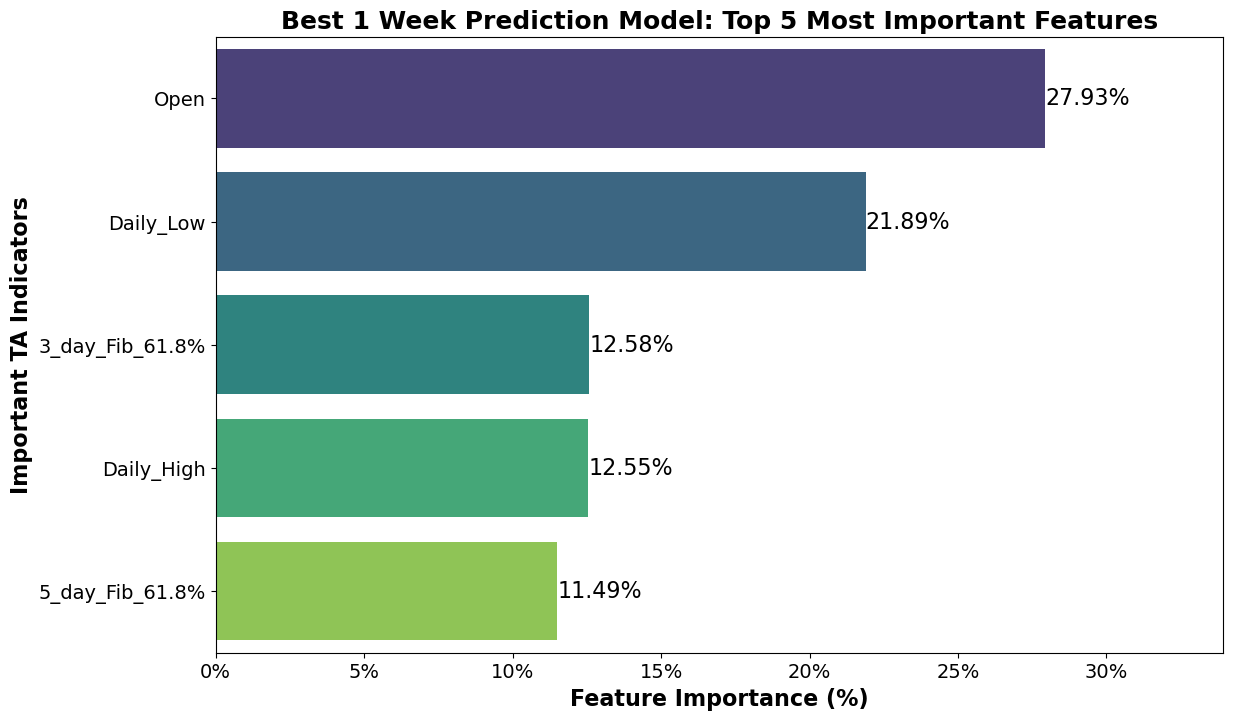

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_1_week_md_3[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_1_week_md_3[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 6)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=16, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=16, fontweight='bold')  # Bigger y-axis title
plt.title("Best 1 Week Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


1 week model to use:

* y_pred_1_week_md_3

In [280]:

stock_data_1_week_test = stock_data_1_week.copy()

stock_data_1_week_test['Date'] = pd.to_datetime(stock_data_1_week_test['Date'], errors='coerce')

columns_to_keep = ['Symbol', 'Date', 'Close']
stock_data_1_week_test.drop(columns = [col for col in stock_data_1_week_test.columns if col not in columns_to_keep], inplace=True)

stock_data_1_week_test = stock_data_1_week_test[stock_data_1_week_test['Date'].isin(stock_data_test_1_week_md_3['Date'])]
stock_data_1_week_test = stock_data_1_week_test.reset_index(drop=True)

predicted_values_1_week = pd.DataFrame(y_pred_1_week_md_3)


one_week_predictions_df = pd.concat([stock_data_1_week_test, predicted_values_1_week], axis=1)

one_week_predictions_df = one_week_predictions_df.rename(columns={0: 'Predicted Price',
                                                         'Close': 'Actual Price',
                                                         'Close_Target': 'Starting Price'})

# Group by Symbol and shift prices within each Symbol group
one_week_predictions_df['Starting Price'] = one_week_predictions_df.groupby('Symbol')['Actual Price'].shift(5)
one_week_predictions_df['Predicted Price For Today'] = one_week_predictions_df.groupby('Symbol')['Predicted Price'].shift(5)
one_week_predictions_df = one_week_predictions_df.dropna(subset=['Predicted Price For Today', 'Starting Price']).reset_index(drop=True)

one_week_predictions_df.head()

,Symbol,Date,Actual Price,Predicted Price,Starting Price,Predicted Price For Today
0,AAPL,2023-02-08,150.173935,149.195465,143.758514,142.324875
1,AAPL,2023-02-09,149.135986,149.232117,149.086594,148.112717
2,AAPL,2023-02-10,149.502304,147.961746,152.724289,149.421249
3,AAPL,2023-02-13,152.313965,149.897659,149.986130,149.471359
4,AAPL,2023-02-14,151.670425,149.897659,152.872559,149.195465


In [281]:
avg_trading_days_per_calendar_year = 252
non_trading_days_per_year = 365 - 252
avg_non_trading_days_per_week = (non_trading_days_per_year / (365)) * 7
avg_trading_days_per_calendar_day = (avg_trading_days_per_calendar_year / 365)
avg_trading_days_1_week = avg_trading_days_per_calendar_day * 7
avg_days_holding_trade_1_week = avg_trading_days_1_week + avg_non_trading_days_per_week

print(f'Average length holding 1 week trade: {avg_days_holding_trade_1_week}')


Average length holding 1 week trade: 7.0


In [282]:
def length_holding_trade(df,avg_trade_length = 7):
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Shift 'Date' by 5 trading days within each 'Symbol'
    df['Trade Entry Date'] = df.groupby('Symbol')['Date'].shift(5)

    # Calculate actual holding time in days
    df['Actual Holding Days'] = (df['Date'] - df['Trade Entry Date']).dt.days

    df['Actual Holding Days'].fillna(avg_trade_length, inplace=True)

    df.drop(columns=['Trade Entry Date'], inplace=True)

    return df

# Example usage
one_week_predictions_df = length_holding_trade(one_week_predictions_df)

one_week_predictions_df.head()

,Symbol,Date,Actual Price,Predicted Price,Starting Price,Predicted Price For Today,Actual Holding Days
0,AAPL,2023-02-08,150.173935,149.195465,143.758514,142.324875,7.0
1,AAPL,2023-02-09,149.135986,149.232117,149.086594,148.112717,7.0
2,AAPL,2023-02-10,149.502304,147.961746,152.724289,149.421249,7.0
3,AAPL,2023-02-13,152.313965,149.897659,149.986130,149.471359,7.0
4,AAPL,2023-02-14,151.670425,149.897659,152.872559,149.195465,7.0


In [283]:
# now we have our dataframe with the actual price, starting price, and predicted price

# avg magnitude of preditions from starting price and avg of magnitude of actual from starting price

total_actual_diff = {}
total_pred_diff = {}
actual_pred_diff = {}

total_actual_diff = 0
total_pred_diff = 0 
actual_pred_diff = 0
for i, row in one_week_predictions_df.iterrows():
    total_actual_diff += (((abs(row['Actual Price'] - row['Starting Price'])) / row['Starting Price']) * 100)
    total_pred_diff += (((abs(row['Predicted Price For Today'] - row['Actual Price'])) / row['Starting Price']) * 100)
    actual_pred_diff += (((abs(row['Predicted Price For Today'] - row['Actual Price'])) / row['Actual Price']) * 100)

# Compute averages by dividing by the number of rows in each DataFrame
average_actual_diff = (total_actual_diff / len(df)) if len(df) > 0 else 0  
average_pred_diff = (total_pred_diff / len(df)) if len(df) > 0 else 0  
avg_pred_actual_diff = (actual_pred_diff / len(df)) if len(df) > 0 else 0 

print(f"Average Percent Magnitude from Starting Price to Actual Price: {average_actual_diff:.2f}%")
print(f"Average Magnitude from Starting Price to Predicted Price: {average_pred_diff:.2f}%")
print(f"Average Magnitude from Actual Price to Predicted Price: {avg_pred_actual_diff:.2f}%\n")


Average Percent Magnitude from Starting Price to Actual Price: 5.21%
Average Magnitude from Starting Price to Predicted Price: 8.60%
Average Magnitude from Actual Price to Predicted Price: 8.51%



In [284]:
# Not sure if i need this or if it's even calculating correctly
# okay nevermind i was calculating it wrong and put my 1 week prediction model
# instead of df, might be good idk
total_pred_up = {}
total_pred_down = {}
total_actual_increase = {}
total_actual_decrease = {}
total_pred_wrong_direction = {}
correct_pred_up = {}
correct_pred_down = {}
correct_pred_up_over_estimate = {}
correct_pred_up_under_estimate = {}
correct_pred_down_over_estimate = {}
correct_pred_down_under_estimate = {}
total_over_estimate_bull_mag_percent = {}
total_under_estimate_bull_mag_percent = {}
total_over_estimate_bear_mag_percent = {}
total_under_estimate_bear_mag_percent = {}

total_pred_up = 0
total_pred_down = 0
total_actual_increase = 0
total_actual_decrease = 0
total_pred_wrong_direction = 0
correct_pred_up = 0
correct_pred_down = 0
correct_pred_up_over_estimate = 0
correct_pred_up_under_estimate = 0
correct_pred_down_over_estimate = 0
correct_pred_down_under_estimate = 0
total_over_estimate_bull_mag_percent = 0
total_under_estimate_bull_mag_percent = 0
total_over_estimate_bear_mag_percent = 0
total_under_estimate_bear_mag_percent = 0
for i, row in one_week_predictions_df.iterrows():
    pred_change = row['Predicted Price For Today'] - row['Starting Price']
    actual_change = row['Actual Price'] - row['Starting Price']
    if pred_change > 0:
        total_pred_up += 1
    elif pred_change < 0:
        total_pred_down += 1

    if actual_change > 0:
        total_actual_increase += 1
    elif actual_change < 0:
        total_actual_decrease += 1

    if pred_change > 0 and actual_change > 0 and pred_change > actual_change:
        correct_pred_up += 1
        correct_pred_up_over_estimate += 1
        total_over_estimate_bull_mag_percent += (abs(pred_change - actual_change) / row['Actual Price']) * 100

    elif pred_change > 0 and actual_change > 0 and pred_change < actual_change:
        correct_pred_up += 1
        correct_pred_up_under_estimate += 1
        total_under_estimate_bull_mag_percent += (abs(pred_change - actual_change) / row['Actual Price']) * 100
    
    elif pred_change < 0  and actual_change < 0 and abs(pred_change) > abs(actual_change):
        correct_pred_down += 1
        correct_pred_down_over_estimate += 1
        total_over_estimate_bear_mag_percent += (abs(pred_change - actual_change) / row['Actual Price']) * 100
    
    elif pred_change < 0  and actual_change < 0 and abs(pred_change) < abs(actual_change):
        correct_pred_down += 1
        correct_pred_down_under_estimate += 1
        total_under_estimate_bear_mag_percent += (abs(pred_change - actual_change) / row['Actual Price']) * 100
    
    if pred_change > 0  and actual_change < 0:
        total_pred_wrong_direction += 1
    elif pred_change < 0  and actual_change > 0:
        total_pred_wrong_direction += 1

correct_price_increase = (((correct_pred_up / total_pred_up
                                ) * 100) if total_pred_up else 0)

correct_price_decrease = (((correct_pred_down / total_pred_down
                                ) * 100) if total_pred_down else 0)

pred_wrong_direction = (((total_pred_wrong_direction / (
    total_pred_up + total_pred_down)) * 100) if (
    total_pred_up + total_pred_down) else 0)

over_estimate_correct_bull_pred = (((correct_pred_up_over_estimate / correct_pred_up
                                ) * 100) if correct_pred_up else 0)

under_estimate_correct_bull_pred = (((correct_pred_up_under_estimate / correct_pred_up
                                ) * 100) if correct_pred_up else 0)

over_estimate_correct_bear_pred = (((correct_pred_down_over_estimate / correct_pred_down
                                ) * 100) if correct_pred_down else 0)

under_estimate_correct_bear_pred = (((correct_pred_down_under_estimate / correct_pred_down
                                ) * 100) if correct_pred_down else 0)

avg_bull_over_estimate_mag_percent = ((total_over_estimate_bull_mag_percent / correct_pred_up_over_estimate
                                ) if correct_pred_up_over_estimate else 0)

avg_bull_under_estimate_mag_percent = ((total_under_estimate_bull_mag_percent / correct_pred_up_under_estimate
                                ) if correct_pred_up_under_estimate else 0)

avg_bear_over_estimate_mag_percent = ((total_over_estimate_bear_mag_percent / correct_pred_down_over_estimate
                                ) if correct_pred_down_over_estimate else 0)

avg_bear_under_estimate_mag_percent = ((total_under_estimate_bear_mag_percent / correct_pred_down_under_estimate
                                ) if correct_pred_down_under_estimate else 0)


print(f'Total correct bullish predictions: {correct_pred_up}')
print(f'Total correct bearish predictions: {correct_pred_down}\n')
print(f'Correct Bullish Predictions: {correct_price_increase:.2f}%')
print(f'Correct Bearish Predictions: {correct_price_decrease:.2f}%\n')
print(f'Missed Direction: {pred_wrong_direction:.2f}%\n')
print(f'Percentage of Overestimated Correct Bullish Predictions: {over_estimate_correct_bull_pred:.2f}%')
print(f'Average magnitude of Overestimated Correct Bullish Predictions: {avg_bull_over_estimate_mag_percent:.2f}%\n')
print(f'Percentage of Underestimated Correct Bullish Predictions: {under_estimate_correct_bull_pred:.2f}%')
print(f'Average magnitude of Underestimated Correct Bullish Predictions: {avg_bull_under_estimate_mag_percent:.2f}%\n')
print(f'Percentage of Overestimated Correct Bearish Predictions: {over_estimate_correct_bear_pred:.2f}%')
print(f'Average magnitude of Overestimated Correct Bearish Predictions: {avg_bear_over_estimate_mag_percent:.2f}%\n')
print(f'Percentage of Underestimated Correct Bearish Predictions: {under_estimate_correct_bear_pred:.2f}%')
print(f'Average magnitude of Underestimated Correct Bearish Predictions: {avg_bear_under_estimate_mag_percent:.2f}%\n')


Total correct bullish predictions: 4026
Total correct bearish predictions: 2444

Correct Bullish Predictions: 57.16%
Correct Bearish Predictions: 43.01%

Missed Direction: 49.06%

Percentage of Overestimated Correct Bullish Predictions: 24.94%
Average magnitude of Overestimated Correct Bullish Predictions: 1.08%

Percentage of Underestimated Correct Bullish Predictions: 75.06%
Average magnitude of Underestimated Correct Bullish Predictions: 2.66%

Percentage of Overestimated Correct Bearish Predictions: 37.52%
Average magnitude of Overestimated Correct Bearish Predictions: 9.80%

Percentage of Underestimated Correct Bearish Predictions: 62.48%
Average magnitude of Underestimated Correct Bearish Predictions: 2.54%



In [285]:
# cool stats, can't use it for trading model because it uses future data
# mean error
# we'll do one for up scenarios, one for down scenarios, then one overall

bullish_count = 0
bearish_count = 0
bullish_sum = 0
bearish_sum = 0
for i, row in one_week_predictions_df.iterrows():
    actual_bull = row['Actual Price'] > row['Starting Price']
    actual_bear = row['Actual Price'] < row['Starting Price']
    predicted_bull = row['Predicted Price For Today'] > row['Starting Price']
    predicted_bear = row['Predicted Price For Today'] < row['Starting Price']
    if actual_bull and predicted_bull:
        bullish_sum += (row['Actual Price'] - row['Predicted Price For Today'])
        bullish_count += 1
    elif actual_bear and predicted_bear:
        bearish_sum += (row['Actual Price'] - row['Predicted Price For Today'])
        bearish_count +=1

bullish_mean_error = (bullish_sum / bullish_count)
bearish_mean_error = (bearish_sum / bearish_count)
bullish_mean_error_percent = ((bullish_mean_error / one_week_predictions_df['Starting Price'].mean()) * 100)
bearish_mean_error_percent = ((bearish_mean_error / one_week_predictions_df['Starting Price'].mean()) * 100)

print(f'Bullish Mean Error One Week Prediction: {bullish_mean_error_percent:.2f}%')
print(f'Bearish Mean Error One Week Prediction: {bearish_mean_error_percent:.2f}%\n')
# this is good stuff
# i think this is slightly better than the overestimation/underestimation calculation i did above

Bullish Mean Error One Week Prediction: 1.24%
Bearish Mean Error One Week Prediction: 10.75%



In [286]:
# cool stats, can't use it for trading model because it uses future data
# mean error
# we'll do one for up scenarios, one for down scenarios, then one overall

bullish_errors = []
bearish_errors = []
for symbol, group in one_week_predictions_df.groupby('Symbol'):

    group['Shifted Predicted Price For Today'] = group['Predicted Price For Today'].shift(1)
    group['Shifted Actual Price'] = group['Actual Price'].shift(1)
    group['Shifted Starting Price'] = group['Starting Price'].shift(1)   

    
    for i, row in group.iterrows():
        actual_bull = row['Shifted Actual Price'] > row['Shifted Starting Price']
        actual_bear = row['Shifted Actual Price'] < row['Shifted Starting Price']
        predicted_bull = row['Shifted Predicted Price For Today'] > row['Shifted Starting Price']
        predicted_bear = row['Shifted Predicted Price For Today'] < row['Shifted Starting Price']
        
        if actual_bull and predicted_bull:
            bullish_errors.append(row['Shifted Actual Price'] - row['Shifted Predicted Price For Today'])
        else:
            bullish_errors.append(0)
    
        if actual_bear and predicted_bear:
            bearish_errors.append(row['Shifted Actual Price'] - row['Shifted Predicted Price For Today'])
        else:
            bearish_errors.append(0)
    
one_week_predictions_df['Bullish Error'] = bullish_errors
one_week_predictions_df['Bearish Error'] = bearish_errors

# Calculate expanding averages within each symbol's group
one_week_predictions_df['Expanding Bullish Error'] = one_week_predictions_df.groupby(
    'Symbol')['Bullish Error'].expanding(min_periods=1).mean(
    ).reset_index(level=0, drop=True)
one_week_predictions_df['Expanding Bearish Error'] = one_week_predictions_df.groupby(
    'Symbol')['Bearish Error'].expanding(min_periods=1).mean(
    ).reset_index(level=0, drop=True)

one_week_predictions_df.head()

,Symbol,Date,Actual Price,Predicted Price,Starting Price,Predicted Price For Today,Actual Holding Days,Bullish Error,Bearish Error,Expanding Bullish Error,Expanding Bearish Error
0,AAPL,2023-02-08,150.173935,149.195465,143.758514,142.324875,7.0,0.0,0.000000,0.0,0.000000
1,AAPL,2023-02-09,149.135986,149.232117,149.086594,148.112717,7.0,0.0,0.000000,0.0,0.000000
2,AAPL,2023-02-10,149.502304,147.961746,152.724289,149.421249,7.0,0.0,0.000000,0.0,0.000000
3,AAPL,2023-02-13,152.313965,149.897659,149.986130,149.471359,7.0,0.0,0.081055,0.0,0.020264
4,AAPL,2023-02-14,151.670425,149.897659,152.872559,149.195465,7.0,0.0,0.000000,0.0,0.016211


In [294]:
# expanding bearish standard dev and bullish standard dev

one_week_predictions_df['Rolling_Bullish_STD'] = (one_week_predictions_df.groupby('Symbol')['Bullish Error'].expanding(min_periods=1).std().reset_index(level=0, drop=True))
one_week_predictions_df['Rolling_Bullish_STD'].fillna(0, inplace=True)

one_week_predictions_df['Rolling_Bearish_STD'] = (one_week_predictions_df.groupby('Symbol')['Bearish Error'].expanding(min_periods=1).std().reset_index(level=0, drop=True))
one_week_predictions_df['Rolling_Bearish_STD'].fillna(0, inplace=True)

one_week_predictions_df.head()

,Symbol,Date,Actual Price,Predicted Price,Starting Price,Predicted Price For Today,Actual Holding Days,Bullish Error,Bearish Error,Expanding Bullish Error,Expanding Bearish Error,Rolling_Bullish_STD,Rolling_Bearish_STD
0,AAPL,2023-02-08,150.173935,149.195465,143.758514,142.324875,7.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,AAPL,2023-02-09,149.135986,149.232117,149.086594,148.112717,7.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,AAPL,2023-02-10,149.502304,147.961746,152.724289,149.421249,7.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,AAPL,2023-02-13,152.313965,149.897659,149.986130,149.471359,7.0,0.0,0.081055,0.0,0.020264,0.0,0.040527
4,AAPL,2023-02-14,151.670425,149.897659,152.872559,149.195465,7.0,0.0,0.000000,0.0,0.016211,0.0,0.036249


In [302]:
# bullish absolute error and rollign mean absolute error
# bearisha bsolute error and rollign mean absolute error
one_week_predictions_df['Abs_Bullish_Error'] = abs(one_week_predictions_df['Bullish Error'])
one_week_predictions_df['Abs_Bearish_Error'] = abs(one_week_predictions_df['Bearish Error'])

one_week_predictions_df['Rolling_Bullish_MAE'] = (one_week_predictions_df.groupby('Symbol')['Abs_Bullish_Error'].expanding(min_periods=1).mean().reset_index(level=0, drop=True))
one_week_predictions_df['Rolling_Bearish_MAE'] = (one_week_predictions_df.groupby('Symbol')['Abs_Bearish_Error'].expanding(min_periods=1).mean().reset_index(level=0, drop=True))

one_week_predictions_df['Rolling_Bullish_MAE'].fillna(0, inplace=True)
one_week_predictions_df['Rolling_Bearish_MAE'].fillna(0, inplace=True)


In [306]:
# normalized bullish and bearish error
one_week_predictions_df['Normalized_Bullish_Abs_Error'] = (one_week_predictions_df['Abs_Bullish_Error'] - one_week_predictions_df['Rolling_Bullish_MAE']) / one_week_predictions_df['Rolling_Bullish_STD']
one_week_predictions_df['Normalized_Bearish_Abs_Error'] = (one_week_predictions_df['Abs_Bearish_Error'] - one_week_predictions_df['Rolling_Bearish_MAE']) / one_week_predictions_df['Rolling_Bearish_STD']

one_week_predictions_df['Normalized_Bullish_Abs_Error'] = one_week_predictions_df.groupby('Symbol')['Normalized_Bullish_Abs_Error'].apply(lambda group: group.fillna(method='bfill')).reset_index(level=0, drop=True)

one_week_predictions_df['Normalized_Bearish_Abs_Error'] = one_week_predictions_df.groupby('Symbol')['Normalized_Bearish_Abs_Error'].apply(lambda group: group.fillna(method='bfill')).reset_index(level=0, drop=True)


In [307]:
one_week_predictions_df.head(20)

,Symbol,Date,Actual Price,Predicted Price,Starting Price,Predicted Price For Today,Actual Holding Days,Bullish Error,Bearish Error,Expanding Bullish Error,Expanding Bearish Error,Rolling_Bullish_STD,Rolling_Bearish_STD,Abs_Bullish_Error,Abs_Bearish_Error,Rolling_Bullish_MAE,Rolling_Bearish_MAE,Normalized_Bullish_Abs_Error,Normalized_Bearish_Abs_Error
0,AAPL,2023-02-08,150.173935,149.195465,143.758514,142.324875,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.474874,1.500000
1,AAPL,2023-02-09,149.135986,149.232117,149.086594,148.112717,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.474874,1.500000
2,AAPL,2023-02-10,149.502304,147.961746,152.724289,149.421249,7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.474874,1.500000
3,AAPL,2023-02-13,152.313965,149.897659,149.986130,149.471359,7.0,0.000000,0.081055,0.000000,0.020264,0.000000,0.040527,0.000000,0.081055,0.000000,0.020264,2.474874,1.500000
4,AAPL,2023-02-14,151.670425,149.897659,152.872559,149.195465,7.0,0.000000,0.000000,0.000000,0.016211,0.000000,0.036249,0.000000,0.000000,0.000000,0.016211,2.474874,-0.447214
5,AAPL,2023-02-15,153.779205,151.308807,150.173935,149.195465,7.0,0.000000,2.474960,0.000000,0.426003,0.000000,1.004304,0.000000,2.474960,0.000000,0.426003,2.474874,2.040177
6,AAPL,2023-02-16,152.175339,151.571762,149.135986,149.232117,7.0,0.000000,0.000000,0.000000,0.365145,0.000000,0.930831,0.000000,0.000000,0.000000,0.365145,2.474874,-0.392278
7,AAPL,2023-02-17,151.026962,150.160614,149.502304,147.961746,7.0,2.943222,0.000000,0.367903,0.319502,1.040586,0.871398,2.943222,0.000000,0.367903,0.319502,2.474874,-0.366654
8,AAPL,2023-02-21,146.997559,148.773468,152.313965,149.897659,8.0,0.000000,0.000000,0.327025,0.284002,0.981074,0.822047,0.000000,0.000000,0.327025,0.284002,-0.333333,-0.345481
9,AAPL,2023-02-22,147.423294,147.188843,151.670425,149.897659,8.0,0.000000,-2.900101,0.294322,-0.034409,0.930729,1.270640,0.000000,2.900101,0.294322,0.545612,-0.316228,1.852994


In [308]:
# get day of the week
import pandas as pd


# Ensure the 'Date' column is in datetime format
one_week_predictions_df['Date'] = pd.to_datetime(one_week_predictions_df['Date'])

# Get the day of the week as a string (e.g., Monday, Tuesday, etc.)
one_week_predictions_df['Day of the Week'] = one_week_predictions_df['Date'].dt.day_name()

# Checking the result for the one week predictions
one_week_predictions_df.head()


,Symbol,Date,Actual Price,Predicted Price,Starting Price,Predicted Price For Today,Actual Holding Days,Bullish Error,Bearish Error,Expanding Bullish Error,Expanding Bearish Error,Rolling_Bullish_STD,Rolling_Bearish_STD,Abs_Bullish_Error,Abs_Bearish_Error,Rolling_Bullish_MAE,Rolling_Bearish_MAE,Normalized_Bullish_Abs_Error,Normalized_Bearish_Abs_Error,Day of the Week
0,AAPL,2023-02-08,150.173935,149.195465,143.758514,142.324875,7.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,2.474874,1.500000,Wednesday
1,AAPL,2023-02-09,149.135986,149.232117,149.086594,148.112717,7.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,2.474874,1.500000,Thursday
2,AAPL,2023-02-10,149.502304,147.961746,152.724289,149.421249,7.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,2.474874,1.500000,Friday
3,AAPL,2023-02-13,152.313965,149.897659,149.986130,149.471359,7.0,0.0,0.081055,0.0,0.020264,0.0,0.040527,0.0,0.081055,0.0,0.020264,2.474874,1.500000,Monday
4,AAPL,2023-02-14,151.670425,149.897659,152.872559,149.195465,7.0,0.0,0.000000,0.0,0.016211,0.0,0.036249,0.0,0.000000,0.0,0.016211,2.474874,-0.447214,Tuesday


In [312]:
def ror(df):
    # Vectorized approach for Predicted ROR
    bullish_move = df['Actual Price'] > df['Starting Price']
    bearish_move = df['Actual Price'] < df['Starting Price']
    
    # For bullish moves (actual_price > starting_price)
    df.loc[bullish_move, 'Predicted ROR'] = (df.loc[bullish_move, 'Predicted Price For Today'] - df.loc[bullish_move, 'Starting Price']) / df.loc[bullish_move, 'Starting Price']
    
    # For bearish moves (actual_price < starting_price)
    df.loc[bearish_move, 'Predicted ROR'] = (df.loc[bearish_move, 'Starting Price'] - df.loc[bearish_move, 'Predicted Price For Today']) / df.loc[bearish_move, 'Starting Price']
    
    # Calculate Rolling Predicted ROR for all rows
    df['Rolling Predicted ROR'] = df.groupby('Symbol')['Predicted ROR'].expanding(min_periods=1).mean().reset_index(level=0, drop=True)


    return df
one_week_predictions_df
one_week_predictions_df = ror(one_week_predictions_df)

one_week_predictions_df['Rolling Predicted ROR'] = one_week_predictions_df['Rolling Predicted ROR'].shift(1)

# Backward fill NaN values in Rolling Predicted ROR
one_week_predictions_df['Rolling Predicted ROR'] = one_week_predictions_df.groupby('Symbol')['Rolling Predicted ROR'].apply(
    lambda group: group.fillna(method='bfill', limit=1)
).reset_index(level=0, drop=True)  


# Now you should have the first NaN values replaced with the first non-NaN values within each 'Symbol'
one_week_predictions_df.head()

,Symbol,Date,Actual Price,Predicted Price,Starting Price,Predicted Price For Today,Actual Holding Days,Bullish Error,Bearish Error,Expanding Bullish Error,...,Rolling_Bearish_STD,Abs_Bullish_Error,Abs_Bearish_Error,Rolling_Bullish_MAE,Rolling_Bearish_MAE,Normalized_Bullish_Abs_Error,Normalized_Bearish_Abs_Error,Day of the Week,Predicted ROR,Rolling Predicted ROR
0,AAPL,2023-02-08,150.173935,149.195465,143.758514,142.324875,7.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,2.474874,1.500000,Wednesday,-0.009973,-0.009973
1,AAPL,2023-02-09,149.135986,149.232117,149.086594,148.112717,7.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,2.474874,1.500000,Thursday,-0.006532,-0.009973
2,AAPL,2023-02-10,149.502304,147.961746,152.724289,149.421249,7.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,2.474874,1.500000,Friday,0.021627,-0.008252
3,AAPL,2023-02-13,152.313965,149.897659,149.986130,149.471359,7.0,0.0,0.081055,0.0,...,0.040527,0.0,0.081055,0.0,0.020264,2.474874,1.500000,Monday,-0.003432,0.001708
4,AAPL,2023-02-14,151.670425,149.897659,152.872559,149.195465,7.0,0.0,0.000000,0.0,...,0.036249,0.0,0.000000,0.0,0.016211,2.474874,-0.447214,Tuesday,0.024053,0.000423


In [313]:
one_week_predictions_df.groupby('Day of the Week')['Predicted ROR'].mean()

Day of the Week
Friday      -0.004576
Monday      -0.004059
Thursday    -0.002426
Tuesday     -0.002698
Wednesday   -0.002898
Name: Predicted ROR, dtype: float64

## 

## bullish mean error hedge
* positive: stock is likely to out perform bullish predictiono
* positive: increase size by bullish % or do nothing, or make position smaller to be safe
* negative: stock might underperform or not go up as much as expected
* negative: take % bullish error out of long position and short stock 

### bearish mean error hedge
* positive: price might not fall as expected
* positive: take % bearish error out of short and go long
* negative: stock could fall more than expected
* negative: do nothing, add bearish % to your position and short  more, or cut % in half and go long, or make positiono smaller

### Long: error hedge
* positive: stock has underperformed compared to expectatioons
* positive: short stock by some % of positiono
* negative: stock has outperformed expectations
* negative: do nothing, add to position, or decrease poosition size to protect profits while still benefitting from upwards movement

### Short: error hedge
* Positive: stock will be more resiliant/rise more than expected
* positive: go long by some % to limit loss
* negative: stock has fallen more than expected
* negative: do nothing, increase short positiono, or cut short poosition to prootect profit while benefitting from strong move

### Long: Error std. dev percent
* High: high degree of uncertainty in stock movement
* high: hedge with some % short
* low: stock is more stable
* low: do nothing, or add to position

### Short: Error std. dev percent
* High: high degree of uncertainty in stock movement
* high: hedge with some % long
* low: stock is more stable
* low: do nothing, or add to position

### Normalized error std dev percent
* instead of using error std dev percent, i normalized it from 0 to 1
* highest i will hedge is 50% if stock has std dev percent of 1
* if normalized std dev percent is 0.1, i will hedge my position 0.5%


#### Scenarios and rules
* if normalized < df['Normalized Error'].quantile(0.25)
* * no hedge for normalized error
 
* if normalized > df['Normalized Error'].quantile(0.25)
* * hedge = 1/2 normalized error
 
* if going long and bullish mean error negative
* * take bullish mean error % out of long and go short with it
 
* if going short and bearish mean error positive
* * take earish mean error % out of long and go short 

In [262]:
one_week_predictions_df.head(20)

,Symbol,Date,Actual Price,Predicted Price,Starting Price,Predicted Price For Today,Actual Holding Days,Error,Abs_Error,Rolling_MAE,Normalized Abs Error,Bullish Mean Error,Bearish Mean Error,Day of the Week,Predicted ROR,Rolling Predicted ROR,Rolling_STD
0,AAPL,2023-02-08,150.173935,149.195465,143.758514,142.324875,7.0,7.849060,7.849060,3.323123,NaN,0.014563,-0.012924,Wednesday,-0.009973,-0.009973,3.918822
1,AAPL,2023-02-09,149.135986,149.232117,149.086594,148.112717,7.0,1.023270,1.023270,3.323123,NaN,0.014563,-0.012924,Thursday,-0.006532,-0.009973,3.918822
2,AAPL,2023-02-10,149.502304,147.961746,152.724289,149.421249,7.0,0.081055,0.081055,3.323123,NaN,0.014563,-0.012924,Friday,0.021627,-0.008252,3.918822
3,AAPL,2023-02-13,152.313965,149.897659,149.986130,149.471359,7.0,2.842606,2.842606,3.323123,NaN,0.014563,-0.012924,Monday,-0.003432,0.001708,3.918822
4,AAPL,2023-02-14,151.670425,149.897659,152.872559,149.195465,7.0,2.474960,2.474960,3.323123,NaN,0.014563,-0.012924,Tuesday,0.024053,0.000423,3.918822
5,AAPL,2023-02-15,153.779205,151.308807,150.173935,149.195465,7.0,4.583740,4.583740,3.323123,NaN,0.014563,-0.012924,Wednesday,-0.006516,0.005149,3.918822
6,AAPL,2023-02-16,152.175339,151.571762,149.135986,149.232117,7.0,2.943222,2.943222,3.323123,NaN,0.014563,-0.012924,Thursday,0.000645,0.003205,3.918822
7,AAPL,2023-02-17,151.026962,150.160614,149.502304,147.961746,7.0,3.065216,3.065216,3.323123,NaN,0.014563,-0.012924,Friday,-0.010305,0.002839,3.918822
8,AAPL,2023-02-21,146.997559,148.773468,152.313965,149.897659,8.0,-2.900101,2.900101,3.323123,NaN,0.014563,-0.012924,Tuesday,0.015864,0.001196,3.918822
9,AAPL,2023-02-22,147.423294,147.188843,151.670425,149.897659,8.0,-2.474365,2.474365,3.323123,NaN,0.014563,-0.012924,Wednesday,0.011688,0.002826,3.918822


In [ ]:
# this one the best onee so far
# RUNNING THIS ONE UPDATE 02/23/2025
# update 2 with leverage

# Trading simulation with no hedging
# typical margin interest rate: 12.5% APR
    # 12.5% / 365 days = 0.03425% per day
# margin requirement: 50%
# we'll say we are trading $10k every position and then we'll run 
# another one where we wrap 10% of our profits back into our position
# avg amount of days holding margin position: 6.57
# if bullish prediction, buy as many stocks as you can, then sell for profit
# for bearish prediction, use margin account to borrow shares to sell, then return to broker and keep difference
    # subtract 
# 0.25% fee per trade
# start with $100,000 for ease
# each trade is 10% of portfolio
# Initialize overall statistics
import numpy as np
import math
overall_results = []


# Group the dataframe by 'Symbol' and run the simulation for each stock separately
for symbol, group in one_week_predictions_df.groupby('Symbol'):
    print(f"\nStarting trading simulation for {symbol}\n")

    # Reset trading account for each stock
    trading_account = 100000
    profit_loss = 0
    bullish_trade_count = 0
    bearish_trade_count = 0
    positive_bullish_trade = 0
    negative_bullish_trade = 0
    positive_bearish_trade = 0
    negative_bearish_trade = 0
    percent_gain = profit_loss / 100000
    
    trade_cost_history = []
    skip_iterations = 0
    
    for i, row in group.iterrows():
        num_trades_per_cycle = 5
        portfolio_loss_prevention = 0.5
        portfolio_trade_percent = 0.05
        starting_price = row['Starting Price']
        actual_price = row['Actual Price']
        predicted_price = row['Predicted Price For Today']
        trade_date = row['Date']
        length_holding_trade = row['Length of Holding Trade (days)']
        

        bullish_pred = predicted_price > starting_price
        actual_bull = actual_price > starting_price
        bearish_pred = predicted_price < starting_price
        actual_bear = actual_price < starting_price
        if skip_iterations > 0:
            skip_iterations -= 1
            continue
               
        if num_trades_per_cycle > (np.log(portfolio_loss_prevention)) / np.log((1 - portfolio_trade_percent)):
            portfolio_trade_percent = math.ceil((1 - np.exp((np.log(portfolio_loss_prevention)) / num_trades_per_cycle)) * 100) / 100
        else:
            portfolio_trade_percent = 0.05
        
        trade_size = 5000
        trade_fee = 0.0025
        stock_borrow_fee_percent = 0.03
        total_days_one_year = 365
        stock_borrow_daily_fee = stock_borrow_fee_percent / total_days_one_year
        starting_trade_cost = 0
        num_iteration_skips = 0
        leverage = 1
        margin_rate = 0.12
        margin_daily_rate = margin_rate / total_days_one_year
        
        
        if bullish_pred:
            bullish_trade_count += 1
            bull_share_amount = (trading_account * portfolio_trade_percent) // starting_price
            bull_starting_trade_cost = (bull_share_amount * starting_price)
            bull_start_trade_fee = bull_starting_trade_cost * trade_fee
            
            if leverage > 1:
                # Leverage
                trading_account -= leverage * (bull_starting_trade_cost + bull_start_trade_fee)
                bull_actual_trade_sell = bull_share_amount * actual_price
                bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
                trading_account += leverage * (bull_actual_trade_sell - bull_actual_trade_fee)
                bullish_profit = ((bull_actual_trade_sell - bull_actual_trade_fee) - (
                    bull_starting_trade_cost + bull_start_trade_fee))
                bull_margin_fee = margin_daily_rate*length_holding_trade*(
                    bull_actual_trade_sell*leverage - bull_actual_trade_sell)
                profit_loss += (leverage * bullish_profit) - (bull_margin_fee)

                if (bull_actual_trade_sell - bull_actual_trade_fee) > (bull_starting_trade_cost + bull_start_trade_fee):
                    positive_bullish_trade += 1
                else: 
                    negative_bullish_trade += 1
            else:
                # No Leverage
                trading_account -= (bull_starting_trade_cost + bull_start_trade_fee)
                bull_actual_trade_sell = bull_share_amount * actual_price
                bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
                trading_account += (bull_actual_trade_sell - bull_actual_trade_fee)
                bullish_profit = ((bull_actual_trade_sell - bull_actual_trade_fee) - (
                    bull_starting_trade_cost + bull_start_trade_fee))
                profit_loss += bullish_profit
            
                if (bull_actual_trade_sell - bull_actual_trade_fee) > (bull_starting_trade_cost + bull_start_trade_fee):
                    positive_bullish_trade += 1
                else: 
                    negative_bullish_trade += 1

        elif bearish_pred:
            bearish_trade_count += 1
            bear_share_amount = (trading_account * portfolio_trade_percent) // starting_price
            bear_starting_short_trade_value = (bear_share_amount * starting_price)
            bear_start_trade_fee = bear_starting_short_trade_value * trade_fee
            bear_start_total_trade = (bear_starting_short_trade_value - bear_start_trade_fee)

            if leverage > 1:
                trading_account += leverage * bear_start_total_trade
                bear_actual_short_trade_value = (bear_share_amount * actual_price)
                bear_actual_trade_fee = bear_actual_short_trade_value * trade_fee
                stock_borrow_trade_fee = bear_starting_short_trade_value * (stock_borrow_daily_fee * length_holding_trade)
                bear_actual_total_trade = (bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee)
                trading_account -= leverage*bear_actual_total_trade
                bear_margin_fee = margin_daily_rate*length_holding_trade*(
                    bear_starting_short_trade_value*leverage - bear_starting_short_trade_value)
                profit_loss += ((leverage * bearish_profit) - (bear_margin_fee))
                if (bear_starting_short_trade_value - bear_start_trade_fee) > (
                    bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee):
                    positive_bearish_trade += 1
                else:
                    negative_bearish_trade += 1
            else:
                trading_account += bear_start_total_trade 
                bear_actual_short_trade_value = (bear_share_amount * actual_price)
                bear_actual_trade_fee = bear_actual_short_trade_value * trade_fee
                stock_borrow_trade_fee = bear_starting_short_trade_value * (stock_borrow_daily_fee * length_holding_trade)
                bear_actual_total_trade = (bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee)
                trading_account -= bear_actual_total_trade
                bearish_profit = (((bear_starting_short_trade_value - bear_start_trade_fee)
                              ) - ((bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee)))
                profit_loss += bearish_profit
                if (bear_starting_short_trade_value - bear_start_trade_fee) > (
                    bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee):
                    positive_bearish_trade += 1
                else:
                    negative_bearish_trade += 1

        # Iteration Skipping
        skip_iterations = num_iteration_skips

        # Check if account has dropped below $1,000 and stop the simulation
        if trading_account <= 5000:
            print(f"Trading account for {symbol} has dropped below $50,000. Stopping simulation.")
            break
        

    # Store results for each stock symbol
    result = {
        'Symbol': symbol,
        'Ending Account Value': trading_account,
        'Total Profit/Loss': profit_loss,
        'Bullish Trades': bullish_trade_count,
        'Bearish Trades': bearish_trade_count,
        'Positive Bullish Trades': positive_bullish_trade,
        'Negative Bullish Trades': negative_bullish_trade,
        'Positive Bearish Trades': positive_bearish_trade,
        'Negative Bearish Trades': negative_bearish_trade,
        'Percent Gain': percent_gain
    }
    overall_results.append(result)

    # Print results for the current stock
    print(f"\nResults for {symbol}:")
    print(f'Trade Account Ending Value: ${trading_account:.2f}')
    print(f'Total Profit/Loss: ${profit_loss:.2f}')
    print(f'Number of Bullish Trades: {bullish_trade_count}')
    print(f'Number of Bearish Trades: {bearish_trade_count}')
    print(f'Number of Positive Bullish Trades: {positive_bullish_trade}')
    print(f'Number of Negative Bullish Trades: {negative_bullish_trade}')
    print(f'Number of Positive Bearish Trades: {positive_bearish_trade}')
    print(f'Number of Negative Bearish Trades: {negative_bearish_trade}')
    print(f'Percentage Gain: {((100000 - profit_loss) / 100000)*100 }')
    
# Convert overall results to a DataFrame for easier analysis
import pandas as pd
trade_simulation_results = pd.DataFrame(overall_results)
print("\nFinal summary of all stocks:")
trade_simulation_results.head()


In [ ]:
trade_simulation_results['Total Profit/Loss ($)'] = trade_simulation_results['Total Profit/Loss'].apply(lambda x: f"${x:,.2f}")
trade_simulation_results['Ending Account Value ($)'] = trade_simulation_results['Ending Account Value'].apply(lambda x: f"${x:,.2f}")
trade_simulation_results = trade_simulation_results[['Symbol', 'Total Profit/Loss ($)', 'Ending Account Value ($)', 
                         'Ending Account Value', 'Total Profit/Loss', 'Bullish Trades',
       'Bearish Trades', 'Positive Bullish Trades', 'Negative Bullish Trades',
       'Positive Bearish Trades', 'Negative Bearish Trades',]]
trade_simulation_results.head()

In [ ]:
one_week_trade_simulation = trade_simulation_results.copy()
starting_trade_account_value = 100000
one_week_trade_simulation = one_week_trade_simulation.sort_values(by = 'Total Profit/Loss', ascending=False)

one_week_trade_simulation['Avg % Return Per Year'] = (((
    one_week_trade_simulation['Ending Account Value'] - starting_trade_account_value) / starting_trade_account_value) / 2) * 100

one_week_trade_simulation['Avg Profit per Trade'] = one_week_trade_simulation['Total Profit/Loss'] / (
    one_week_trade_simulation['Bullish Trades'] + one_week_trade_simulation['Bearish Trades'])
one_week_trade_simulation['Avg % Return Per Year'] = (((
    one_week_trade_simulation['Ending Account Value'] - starting_trade_account_value) / starting_trade_account_value) / 2) * 100
one_week_trade_simulation = one_week_trade_simulation.sort_values(by = 'Avg % Return Per Year', ascending=False)
one_week_trade_simulation.head()

In [ ]:
# One Week Prediction Trade Simulation Results
avg_profit_per_year = (one_week_trade_simulation['Total Profit/Loss'].mean()) / 2
print(f'Average Profit Per Year: ${avg_profit_per_year:,.2f}')

win_ratio = one_week_trade_simulation[one_week_trade_simulation['Total Profit/Loss'] > 0].shape[0] / one_week_trade_simulation.shape[0]
print(f'win ratio: {win_ratio*100}%')
# sharp ratio

sharp_ratio = (one_week_trade_simulation['Total Profit/Loss'].mean() / one_week_trade_simulation['Total Profit/Loss'].std())
print(f'sharp ratio: {sharp_ratio:.2f}')

avg_percent_yearly_return = one_week_trade_simulation['Avg % Return Per Year'].mean()
print(f'Avg Yearly Return: {avg_percent_yearly_return:.2f}%')

avg_profit_per_trade = one_week_trade_simulation['Avg Profit per Trade'].mean()
print(f'Average Profit Per Trade: ${avg_profit_per_trade:,.2f}')


all features, no corr test and no feature imp cutoff
* Average Profit Per Year: $-6,023.03
* win ratio: 4.0%
* sharp ratio: -1.27
* Avg Yearly Return: -6.02%
* Average Profit Per Trade: $-23.67

In [263]:
one_week_predictions_df.head()

,Symbol,Date,Actual Price,Predicted Price,Starting Price,Predicted Price For Today,Actual Holding Days,Error,Abs_Error,Rolling_MAE,Normalized Abs Error,Bullish Mean Error,Bearish Mean Error,Day of the Week,Predicted ROR,Rolling Predicted ROR,Rolling_STD
0,AAPL,2023-02-08,150.173935,149.195465,143.758514,142.324875,7.0,7.849060,7.849060,3.323123,NaN,0.014563,-0.012924,Wednesday,-0.009973,-0.009973,3.918822
1,AAPL,2023-02-09,149.135986,149.232117,149.086594,148.112717,7.0,1.023270,1.023270,3.323123,NaN,0.014563,-0.012924,Thursday,-0.006532,-0.009973,3.918822
2,AAPL,2023-02-10,149.502304,147.961746,152.724289,149.421249,7.0,0.081055,0.081055,3.323123,NaN,0.014563,-0.012924,Friday,0.021627,-0.008252,3.918822
3,AAPL,2023-02-13,152.313965,149.897659,149.986130,149.471359,7.0,2.842606,2.842606,3.323123,NaN,0.014563,-0.012924,Monday,-0.003432,0.001708,3.918822
4,AAPL,2023-02-14,151.670425,149.897659,152.872559,149.195465,7.0,2.474960,2.474960,3.323123,NaN,0.014563,-0.012924,Tuesday,0.024053,0.000423,3.918822


In [ ]:
# this one the best onee so far
# RUNNING THIS ONE UPDATE 02/23/2025
# update 3 with hedging

# Trading simulation with no hedging
# typical margin interest rate: 12.5% APR
    # 12.5% / 365 days = 0.03425% per day
# margin requirement: 50%
# we'll say we are trading $10k every position and then we'll run 
# another one where we wrap 10% of our profits back into our position
# avg amount of days holding margin position: 6.57
# if bullish prediction, buy as many stocks as you can, then sell for profit
# for bearish prediction, use margin account to borrow shares to sell, then return to broker and keep difference
    # subtract 
# 0.25% fee per trade
# start with $100,000 for ease
# each trade is 10% of portfolio
# Initialize overall statistics
import numpy as np
import math
overall_results = []


# Group the dataframe by 'Symbol' and run the simulation for each stock separately
for symbol, group in one_week_predictions_df.groupby('Symbol'):
    print(f"\nStarting trading simulation for {symbol}\n")

    # Reset trading account for each stock
    trading_account = 100000
    profit_loss = 0
    bullish_trade_count = 0
    bearish_trade_count = 0
    positive_bullish_trade = 0
    negative_bullish_trade = 0
    positive_bearish_trade = 0
    negative_bearish_trade = 0
    percent_gain = (profit_loss / 100000) * 100
    
    skip_iterations = 0
    
    for i, row in group.iterrows():

        # Features to reference
        starting_price = row['Starting Price']
        actual_price = row['Actual Price']
        predicted_price = row['Predicted Price For Today']
        trade_date = row['Date']
        length_holding_trade = row['Length of Holding Trade (days)']
        bullish_mean_error = row['Bullish Mean Error']
        bearish_mean_error = row['Bearish Mean Error']
        norm_error = row['Normalized Error']
        # predicted_var = row['Predicted VaR']
        # predicted_cvar = row['Predicted CVaR']
        pred_ror = ['Rolling Predicted ROR']
        
        bullish_pred = predicted_price > starting_price
        actual_bull = actual_price > starting_price
        bearish_pred = predicted_price < starting_price
        actual_bear = actual_price < starting_price
        

        # Timeframe Prediction information
        num_trades_per_cycle = 5

        # % Portfolio risked per trade
        portfolio_trade_percent = 0.1
        
        # If running trades everyday, prevents trader from depleting portfolio before first sell
        portfolio_loss_prevention = 0.1
        
        if num_trades_per_cycle > (np.log(portfolio_loss_prevention)) / np.log((1 - portfolio_trade_percent)):
            portfolio_trade_percent = math.ceil((1 - np.exp((np.log(portfolio_loss_prevention)) / num_trades_per_cycle)) * 100) / 100
        else:
            portfolio_trade_percent = 0.05
      

        # Terms for hedging
        
        norm_error_low_quant = 0.05
        norm_error = row['Normalized Error']
        # norm_error = Normalized Error % of the Standard Deviation
        # if norm_error > 0.05
            # hedge in opposite position 
            # total_trade_position_value = trade_size
            # norm_error_hedge = (total_trade_position_value * (1/2 norm_error))
            # Predicted trade position value = total_trade_position_value - norm_error_hedge
        # if norm_error < 0.05
            # No hedge
        
        bullish_mean_error = row['Bullish Mean Error']
        bearish_mean_error = row['Bearish Mean Error']
        # Bullish mean error: average error of bullish predicted stock price
            # Only used if stock price predicted to increase
            # If bullish_mean_error > 0
                # No hedge
            # If bullish_mean_error < 0
                # Hedge in opposite direction
                # total_trade_position_value = trade_size
                # bullish_mean_error_hedge = (total_trade_position_value * abs(bullish_mean_error))
                # Predicted trade position value = total_trade_position_value - bullish_mean_error_hedge
        # Bearish Mean Error: average erroor of bearish predicted stock price
            # Only used if stock price predicted to decrease
            # If bearish_mean_error < 0
                # No hedge
            # If bearish_mean_error > 0
                # Hedge in opposite direction
                # total_trade_position_value = trade_size
                # bearish_mean_error_hedge = (total_trade_position_value * bearish_mean_error)
                # Predicted trade position value = total_trade_position_value - bearish_mean_error_hedge
        # Double Hedge
            # Bullish Scenario
                # bullish_mean_error < 0 and norm_error > 0.05
                # total_trade_position_value = trade_size
                # total_hedge = (1/2 norm_error) + abs(bullish_mean_error)
                # hedge_position_size = (total_trade_position_value * total_hedge)
                # Predicted trade position value = total_trade_position_value - hedge_position_size
            # Bearish Scenario
                # bearish_mean_error > 0 and norm_error > 0.05
                # total_trade_position_value = trade_size
                # total_hedge = (1/2 norm_error) + bearish_mean_error
                # hedge_position_size = (total_trade_position_value * total_hedge)
                # Predicted trade position value = total_trade_position_value - hedge_position_size


        # Iteration Skipper: Limit Number of trades over testing timeframe
        num_iteration_skips =0        
        if skip_iterations > 0:
            skip_iterations -= 1
            continue

        # % Portfolio risked per trade
        # portfolio_trade_percent = 0.05

        
        # % Portfolio risked per trade
        # portfolio_trade_percent = 0.05
        # If running trades everyday, prevents trader from depleting portfolio before first sell
        portfolio_loss_prevention = 0.1
        
        if num_trades_per_cycle > (np.log(portfolio_loss_prevention)) / np.log((1 - portfolio_trade_percent)):
            portfolio_trade_percent = math.ceil((1 - np.exp((np.log(portfolio_loss_prevention)) / num_trades_per_cycle)) * 100) / 100
        else:
            portfolio_trade_percent = 0.05

        # Position size per trade        
        trade_size = trading_account * portfolio_trade_percent

        # Trade fee: trade_size * trade_fee
        trade_fee = 0.0025

        # Stock borrow fee (for shorting): 
            # starting_short_trade_cost * (stock_borrow_daily_fee * number of days holding stocks)
        stock_borrow_fee_percent = 0.03
        total_days_one_year = 365
        stock_borrow_daily_fee = stock_borrow_fee_percent / total_days_one_year

        # Leverage declaration and margin fee
        leverage = 1
        margin_rate = 0.12
        margin_daily_rate = margin_rate / total_days_one_year
        
# Bullish Prediction       
        if bullish_pred:
            
            # Mean Error Hedge and norm_error hedge
            if bullish_mean_error < 0 and norm_error > norm_error_low_quant:
                bullish_trade_count += 1
                total_trade_position_value = trade_size
                
                bull_hedge_value = total_trade_position_value * (1*((abs(bullish_mean_error) + (norm_error/2)) + abs(predicted_cvar)))
                bull_hedge_share_amount = math.ceil(bull_hedge_value / starting_price)
                bull_hedge_trade_cost = bull_hedge_share_amount * starting_price
                bull_hedge_trade_fee = bull_hedge_trade_cost * trade_fee
                
                bull_starting_trade_value = total_trade_position_value - bull_hedge_value
                bull_starting_share_amount = math.ceil(bull_starting_trade_value / starting_price)
                bull_starting_trade_cost = bull_starting_share_amount * starting_price
                bull_starting_trade_fee = bull_starting_trade_cost * trade_fee
            
                trading_account -= (bull_starting_trade_cost + bull_starting_trade_fee)
                trading_account += (bull_hedge_trade_cost - bull_hedge_trade_fee)

                bull_actual_trade_sell = bull_starting_share_amount * actual_price
                bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
                
                trading_account += (bull_actual_trade_sell - bull_actual_trade_fee)

                bull_hedge_actual_trade_value = (bull_hedge_share_amount * actual_price)
                bull_hedge_actual_trade_fee = bull_hedge_actual_trade_value * trade_fee
                bull_hedge_stock_borrow_fee = bull_hedge_trade_cost * (stock_borrow_daily_fee * length_holding_trade)

                trading_account -= (bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)

                bearish_profit = (bull_hedge_trade_cost - bull_hedge_trade_fee) - (
                    bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)
                  
                bullish_profit = ((bull_actual_trade_sell - bull_actual_trade_fee) - (
                    bull_starting_trade_cost + bull_starting_trade_fee))

                profit_loss += bullish_profit
                profit_loss += bearish_profit

                if ((bull_actual_trade_sell - bull_actual_trade_fee) + (bull_hedge_trade_cost - bull_hedge_trade_fee)
                   ) > ((bull_starting_trade_cost + bull_starting_trade_fee)) + (
                       (bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)):
                    positive_bullish_trade += 1
                else: 
                    negative_bullish_trade += 1
                    
            # norm_error hedge only
            elif bullish_mean_error > 0 and norm_error > norm_error_low_quant:
                bullish_trade_count += 1
                total_trade_position_value = trade_size
                
                bull_hedge_value = total_trade_position_value * (1*((norm_error/2) + abs(predicted_cvar)))
                bull_hedge_share_amount = math.ceil(bull_hedge_value / starting_price)
                bull_hedge_trade_cost = bull_hedge_share_amount * starting_price
                bull_hedge_trade_fee = bull_hedge_trade_cost * trade_fee
                
                bull_starting_trade_value = total_trade_position_value - bull_hedge_value
                bull_starting_share_amount = math.ceil(bull_starting_trade_value / starting_price)
                bull_starting_trade_cost = bull_starting_share_amount * starting_price
                bull_starting_trade_fee = bull_starting_trade_cost * trade_fee
            
                trading_account -= (bull_starting_trade_cost + bull_starting_trade_fee)
                trading_account += (bull_hedge_trade_cost - bull_hedge_trade_fee)

                bull_actual_trade_sell = bull_starting_share_amount * actual_price
                bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
                
                trading_account += (bull_actual_trade_sell - bull_actual_trade_fee)

                bull_hedge_actual_trade_value = (bull_hedge_share_amount * actual_price)
                bull_hedge_actual_trade_fee = bull_hedge_actual_trade_value * trade_fee
                bull_hedge_stock_borrow_fee = bull_hedge_trade_cost * (stock_borrow_daily_fee * length_holding_trade)

                trading_account -= (bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)

                bearish_profit = (bull_hedge_trade_cost - bull_hedge_trade_fee) - (
                    bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)
                  
                bullish_profit = ((bull_actual_trade_sell - bull_actual_trade_fee) - (
                    bull_starting_trade_cost + bull_starting_trade_fee))

                profit_loss += bullish_profit
                profit_loss += bearish_profit

                if ((bull_actual_trade_sell - bull_actual_trade_fee) + (bull_hedge_trade_cost - bull_hedge_trade_fee)
                   ) > ((bull_starting_trade_cost + bull_starting_trade_fee)) + (
                       (bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)):
                    positive_bullish_trade += 1
                else: 
                    negative_bullish_trade += 1

            

                    # Mean Error Hedge only
            elif bullish_mean_error < 0 and norm_error < norm_error_low_quant:
                bullish_trade_count += 1
                total_trade_position_value = trade_size
                
                bull_hedge_value = total_trade_position_value * (1*((abs(bullish_mean_error)) + abs(predicted_cvar)))
                bull_hedge_share_amount = math.ceil(bull_hedge_value / starting_price)
                bull_hedge_trade_cost = bull_hedge_share_amount * starting_price
                bull_hedge_trade_fee = bull_hedge_trade_cost * trade_fee
                
                bull_starting_trade_value = total_trade_position_value - bull_hedge_value
                bull_starting_share_amount = math.ceil(bull_starting_trade_value / starting_price)
                bull_starting_trade_cost = bull_starting_share_amount * starting_price
                bull_starting_trade_fee = bull_starting_trade_cost * trade_fee
            
                trading_account -= (bull_starting_trade_cost + bull_starting_trade_fee)
                trading_account += (bull_hedge_trade_cost - bull_starting_trade_fee)

                bull_actual_trade_sell = bull_starting_share_amount * actual_price
                bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
                
                trading_account += (bull_actual_trade_sell - bull_actual_trade_fee)

                bull_hedge_actual_trade_value = (bull_hedge_share_amount * actual_price)
                bull_hedge_actual_trade_fee = bull_hedge_actual_trade_value * trade_fee
                bull_hedge_stock_borrow_fee = bull_hedge_trade_cost * (stock_borrow_daily_fee * length_holding_trade)

                trading_account -= (bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)

                bearish_profit = (bull_hedge_trade_cost - bull_hedge_trade_fee) - (
                    bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)
                  
                bullish_profit = ((bull_actual_trade_sell - bull_actual_trade_fee) - (
                    bull_starting_trade_cost + bull_starting_trade_fee))

                profit_loss += bullish_profit
                profit_loss += bearish_profit

                if ((bull_actual_trade_sell - bull_actual_trade_fee) + (bull_hedge_trade_cost - bull_hedge_trade_fee)
                   ) > ((bull_starting_trade_cost + bull_starting_trade_fee)) + (
                       (bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)):
                    positive_bullish_trade += 1
                else: 
                    negative_bullish_trade += 1

            
           # No Hedge    
            else:
                bullish_trade_count += 1
                total_trade_position_value = trade_size
                
                # bull_hedge_value = total_trade_position_value * (abs(bullish_mean_error)
                # bull_hedge_share_amount = bull_hedge_value // starting_price
                # bull_hedge_trade_cost = bull_hedge_share_amount * starting_price
                # bull_hedge_trade_fee = bull_hedge_trade_cost * trade_fee
                
                # bull_starting_trade_value = total_trade_position_value - bull_hedge_value
                bull_starting_trade_value = total_trade_position_value
                bull_starting_share_amount = math.ceil(bull_starting_trade_value / starting_price)
                bull_starting_trade_cost = bull_starting_share_amount * starting_price
                bull_starting_trade_fee = bull_starting_trade_cost * trade_fee
            
                trading_account -= (bull_starting_trade_cost + bull_starting_trade_fee)
                # trading_account += (bull_hedge_trade_cost - bull_starting_trade_fee)

                bull_actual_trade_sell = bull_starting_share_amount * actual_price
                bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
                
                trading_account += (bull_actual_trade_sell - bull_actual_trade_fee)

                # bull_hedge_actual_trade_value = (bull_hedge_share_amount * actual_price)
                # bull_hedge_actual_trade_fee = bull_hedge_actual_trade_value * trade_fee
                # bull_hedge_stock_borrow_fee = bull_hedge_trade_cost * (stock_borrow_daily_fee * length_holding_trade)

                # trading_account -= (bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)

                # bearish_profit = (bull_hedge_trade_cost - bull_hedge_trade_fee) - (
                #     bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)
                  
                bullish_profit = ((bull_actual_trade_sell - bull_actual_trade_fee) - (
                    bull_starting_trade_cost + bull_starting_trade_fee))

                profit_loss += bullish_profit


                if (bull_actual_trade_sell - bull_actual_trade_fee) > (bull_starting_trade_cost + bull_starting_trade_fee):
                    positive_bullish_trade += 1
                else: 
                    negative_bullish_trade += 1
            

            # bull_share_amount = (trade_size) // starting_price
            # bull_starting_trade_cost = (bull_share_amount * starting_price)
            # bull_starting_trade_fee = bull_starting_trade_cost * trade_fee
            


# Bearish Prediction        
        elif bearish_pred:
            
            # Bearish mean error + norm_error hedge
            if bearish_mean_error > 0 and norm_error > norm_error_low_quant:
                bearish_trade_count += 1
                total_trade_position_value = trade_size
            
                bear_hedge_value = total_trade_position_value * (1*((abs(bearish_mean_error) + (norm_error/2)) + abs(predicted_cvar)))
                bear_hedge_share_amount = math.ceil(bear_hedge_value / starting_price)
                bear_hedge_trade_cost = bear_hedge_share_amount * starting_price
                bear_hedge_trade_fee = bear_hedge_trade_cost * trade_fee
                
                bear_starting_trade_value = total_trade_position_value - bear_hedge_value
                bear_starting_share_amount = math.ceil(bear_starting_trade_value / starting_price)
                bear_starting_trade_cost = bear_starting_share_amount * starting_price
                bear_starting_trade_fee = bear_starting_trade_cost * trade_fee
            
                trading_account -= (bear_hedge_trade_cost + bear_hedge_trade_fee)
                trading_account += (bear_starting_trade_cost - bear_starting_trade_fee)
                
                bear_actual_trade_value = bear_starting_share_amount * actual_price
                bear_actual_trade_fee = bear_actual_trade_value * trade_fee
                bear_actual_stock_borrow_fee = bear_hedge_trade_cost * (stock_borrow_daily_fee * length_holding_trade)
                
                trading_account -= (bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)

                bear_hedge_actual_trade_value = (bear_hedge_share_amount * actual_price)
                bear_hedge_actual_trade_fee = bear_hedge_actual_trade_value * trade_fee

                trading_account += (bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee)

                bearish_profit = (bear_starting_trade_cost - bear_starting_trade_fee) - (
                    bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)
                  
                bullish_profit = ((bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee) - (
                    bear_hedge_trade_cost + bear_hedge_trade_fee))

                profit_loss += bullish_profit
                profit_loss += bearish_profit

                if ((bear_starting_trade_cost - bear_starting_trade_fee) + (
                    bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee)) > (
                    (bear_hedge_trade_cost + bear_hedge_trade_fee) + (
                        (bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee))):
                    positive_bearish_trade += 1
                else: 
                    negative_bearish_trade += 1



            # norm_error hedge only
            elif bearish_mean_error < 0 and norm_error > norm_error_low_quant:
                bearish_trade_count += 1
                total_trade_position_value = trade_size
                
                bear_hedge_value = total_trade_position_value * (1*((norm_error/2) + abs(predicted_cvar)))
                bear_hedge_share_amount = math.ceil(bear_hedge_value / starting_price)
                bear_hedge_trade_cost = bear_hedge_share_amount * starting_price
                bear_hedge_trade_fee = bear_hedge_trade_cost * trade_fee
                
                bear_starting_trade_value = total_trade_position_value - bear_hedge_value
                bear_starting_share_amount = math.ceil(bear_starting_trade_value / starting_price)
                bear_starting_trade_cost = bear_starting_share_amount * starting_price
                bear_starting_trade_fee = bear_starting_trade_cost * trade_fee
                
                trading_account -= (bear_hedge_trade_cost + bear_hedge_trade_fee)
                trading_account += (bear_starting_trade_cost - bear_starting_trade_fee)
                
                bear_actual_trade_value = bear_starting_share_amount * actual_price
                bear_actual_trade_fee = bear_actual_trade_value * trade_fee
                bear_actual_stock_borrow_fee = bear_hedge_trade_cost * (stock_borrow_daily_fee * length_holding_trade)
                
                trading_account -= (bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)
                
                bear_hedge_actual_trade_value = (bear_hedge_share_amount * actual_price)
                bear_hedge_actual_trade_fee = bear_hedge_actual_trade_value * trade_fee
                
                trading_account += (bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee)
                
                bearish_profit = (bear_starting_trade_cost - bear_starting_trade_fee) - (
                    bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)
                  
                bullish_profit = ((bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee) - (
                    bear_hedge_trade_cost + bear_hedge_trade_fee))
                
                profit_loss += bullish_profit
                profit_loss += bearish_profit
                
                if ((bear_starting_trade_cost - bear_starting_trade_fee) + (
                    bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee)) > (
                    (bear_hedge_trade_cost + bear_hedge_trade_fee) + (
                        (bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee))):
                    positive_bearish_trade += 1
                else: 
                    negative_bearish_trade += 1
# (1*

            # bearish mean error hedge only
            elif bearish_mean_error > 0 and norm_error < norm_error_low_quant:
                bearish_trade_count += 1
                total_trade_position_value = trade_size
                
                bear_hedge_value = total_trade_position_value * (1*((abs(bearish_mean_error)) + abs(predicted_cvar)))
                bear_hedge_share_amount = math.ceil(bear_hedge_value / starting_price)
                bear_hedge_trade_cost = bear_hedge_share_amount * starting_price
                bear_hedge_trade_fee = bear_hedge_trade_cost * trade_fee
                
                bear_starting_trade_value = total_trade_position_value - bear_hedge_value
                bear_starting_share_amount = math.ceil(bear_starting_trade_value / starting_price)
                bear_starting_trade_cost = bear_starting_share_amount * starting_price
                bear_starting_trade_fee = bear_starting_trade_cost * trade_fee
                
                trading_account -= (bear_hedge_trade_cost + bear_hedge_trade_fee)
                trading_account += (bear_starting_trade_cost - bear_starting_trade_fee)
                
                bear_actual_trade_value = bear_starting_share_amount * actual_price
                bear_actual_trade_fee = bear_actual_trade_value * trade_fee
                bear_actual_stock_borrow_fee = bear_hedge_trade_cost * (stock_borrow_daily_fee * length_holding_trade)
                
                trading_account -= (bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)
                
                bear_hedge_actual_trade_value = (bear_hedge_share_amount * actual_price)
                bear_hedge_actual_trade_fee = bear_hedge_actual_trade_value * trade_fee
                
                trading_account += (bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee)
                
                bearish_profit = (bear_starting_trade_cost - bear_starting_trade_fee) - (
                    bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)
                  
                bullish_profit = ((bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee) - (
                    bear_hedge_trade_cost + bear_hedge_trade_fee))
                
                profit_loss += bullish_profit
                profit_loss += bearish_profit
                
                if ((bear_starting_trade_cost - bear_starting_trade_fee) + (
                    bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee)) > (
                    (bear_hedge_trade_cost + bear_hedge_trade_fee) + (
                        (bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee))):
                    positive_bearish_trade += 1
                else: 
                    negative_bearish_trade += 1

        


            else:
                total_trade_position_value = trade_size
                bearish_trade_count += 1
                
                # bear_hedge_value = total_trade_position_value * (abs(bearish_mean_error) + (norm_error/2))
                # bear_hedge_share_amount = bear_hedge_value // starting_price
                # bear_hedge_trade_cost = bear_hedge_share_amount * starting_price
                # bear_hedge_trade_fee = bear_hedge_trade_cost * trade_fee
                
                # bear_starting_trade_value = total_trade_position_value - bear_hedge_value
                bear_starting_trade_value = total_trade_position_value
                bear_starting_share_amount = math.ceil(bear_starting_trade_value / starting_price)
                bear_starting_trade_cost = bear_starting_share_amount * starting_price
                bear_starting_trade_fee = bear_starting_trade_cost * trade_fee
                
                # trading_account -= (bear_hedge_trade_cost + bear_hedge_trade_fee)
                trading_account += (bear_starting_trade_cost - bear_starting_trade_fee)
                
                bear_actual_trade_value = bear_starting_share_amount * actual_price
                bear_actual_trade_fee = bear_actual_trade_value * trade_fee
                bear_actual_stock_borrow_fee = bear_starting_trade_cost * (stock_borrow_daily_fee * length_holding_trade)
                
                trading_account -= (bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)
                
                # bear_hedge_actual_trade_value = (bear_hedge_share_amount * actual_price)
                # bear_hedge_actual_trade_fee = bear_hedge_actual_trade_value * trade_fee
                
                # trading_account += (bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee)
                
                bearish_profit = (bear_starting_trade_cost - bear_starting_trade_fee) - (
                    bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)
                  
                # bullish_profit = ((bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee) - (
                #     bear_hedge_trade_cost + bear_hedge_trade_fee))
                
                
                profit_loss += bearish_profit
                
                if (bear_starting_trade_cost - bear_starting_trade_fee) > (
                    bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee):
                    positive_bearish_trade += 1
                else: 
                    negative_bearish_trade += 1
                    


        # Iteration Skipping
        skip_iterations = num_iteration_skips

        # Check if account has dropped below $1,000 and stop the simulation
        if trading_account <= 5000:
            print(f"Trading account for {symbol} has dropped below $50,000. Stopping simulation.")
            break
        

    # Store results for each stock symbol
    result = {
        'Symbol': symbol,
        'Ending Account Value': trading_account,
        'Total Profit/Loss': profit_loss,
        'Bullish Trades': bullish_trade_count,
        'Bearish Trades': bearish_trade_count,
        'Positive Bullish Trades': positive_bullish_trade,
        'Negative Bullish Trades': negative_bullish_trade,
        'Positive Bearish Trades': positive_bearish_trade,
        'Negative Bearish Trades': negative_bearish_trade,
        'Percent Gain': percent_gain
    }
    overall_results.append(result)

    # Print results for the current stock
    print(f"\nResults for {symbol}:")
    print(f'Trade Account Ending Value: ${trading_account:.2f}')
    print(f'Total Profit/Loss: ${profit_loss:.2f}')
    print(f'Number of Bullish Trades: {bullish_trade_count}')
    print(f'Number of Bearish Trades: {bearish_trade_count}')
    print(f'Number of Positive Bullish Trades: {positive_bullish_trade}')
    print(f'Number of Negative Bullish Trades: {negative_bullish_trade}')
    print(f'Number of Positive Bearish Trades: {positive_bearish_trade}')
    print(f'Number of Negative Bearish Trades: {negative_bearish_trade}')
    print(f'Percentage Gain: {(profit_loss / 100000) * 100}')
    
# Convert overall results to a DataFrame for easier analysis
import pandas as pd
trade_simulation_results = pd.DataFrame(overall_results)
print("\nFinal summary of all stocks:")
trade_simulation_results.head()


In [ ]:
one_week_predictions_df.head()

In [ ]:
trade_simulation_results['Total Profit/Loss ($)'] = trade_simulation_results['Total Profit/Loss'].apply(lambda x: f"${x:,.2f}")
trade_simulation_results['Ending Account Value ($)'] = trade_simulation_results['Ending Account Value'].apply(lambda x: f"${x:,.2f}")
trade_simulation_results = trade_simulation_results[['Symbol', 'Total Profit/Loss ($)', 'Ending Account Value ($)', 
                         'Ending Account Value', 'Total Profit/Loss', 'Bullish Trades',
       'Bearish Trades', 'Positive Bullish Trades', 'Negative Bullish Trades',
       'Positive Bearish Trades', 'Negative Bearish Trades',]]
trade_simulation_results.head()

In [ ]:
one_week_trade_simulation = trade_simulation_results.copy()
starting_trade_account_value = 100000
one_week_trade_simulation = one_week_trade_simulation.sort_values(by = 'Total Profit/Loss', ascending=False)

one_week_trade_simulation['Avg % Return Per Year'] = (((
    one_week_trade_simulation['Ending Account Value'] - starting_trade_account_value) / starting_trade_account_value) / 2) * 100

one_week_trade_simulation['Avg Profit per Trade'] = one_week_trade_simulation['Total Profit/Loss'] / (
    one_week_trade_simulation['Bullish Trades'] + one_week_trade_simulation['Bearish Trades'])
one_week_trade_simulation['Avg % Return Per Year'] = (((
    one_week_trade_simulation['Ending Account Value'] - starting_trade_account_value) / starting_trade_account_value) / 2) * 100
one_week_trade_simulation = one_week_trade_simulation.sort_values(by = 'Avg % Return Per Year', ascending=False)
one_week_trade_simulation.head()

In [ ]:
# One Week Prediction Trade Simulation Results
avg_profit_per_year = (one_week_trade_simulation['Total Profit/Loss'].mean()) / 2
print(f'Average Profit Per Year: ${avg_profit_per_year:,.2f}')

win_ratio = one_week_trade_simulation[one_week_trade_simulation['Total Profit/Loss'] > 0].shape[0] / one_week_trade_simulation.shape[0]
print(f'win ratio: {win_ratio*100}%')
# sharp ratio

sharp_ratio = (one_week_trade_simulation['Total Profit/Loss'].mean() / one_week_trade_simulation['Total Profit/Loss'].std())
print(f'sharp ratio: {sharp_ratio:.2f}')

avg_percent_yearly_return = one_week_trade_simulation['Avg % Return Per Year'].mean()
print(f'Avg Yearly Return: {avg_percent_yearly_return:.2f}%')

avg_profit_per_trade = one_week_trade_simulation['Avg Profit per Trade'].mean()
print(f'Average Profit Per Trade: ${avg_profit_per_trade:,.2f}')


1 week 99% PCA
* Average Profit Per Year: $-6,782.47
* win ratio: 1.507537688442211%
* sharp ratio: -2.43
* Avg Yearly Return: -6.78%
* Average Profit Per Trade: $-26.80

1 week 90% PCA
* Average Profit Per Year: $-6,999.73
* win ratio: 2.0100502512562812%
* sharp ratio: -2.17
* Avg Yearly Return: -7.02%
* Average Profit Per Trade: $-27.51

1 week non-cpa
* Average Profit Per Year: $-5,209.62
* win ratio: 2.512562814070352%
* sharp ratio: -2.19
* Avg Yearly Return: -5.21%
* Average Profit Per Trade: $-20.64

In [ ]:
one_week_trade_simulation = one_week_trade_simulation.sort_values(by = 'Avg % Return Per Year', ascending=False)
one_week_trade_simulation.head(20)

### One Week
* Average Profit Per Year: 39299.690793693655
* win ratio: 98.5%
* sharp ratio: 1.38
* Avg Yearly Return: 39.30%
* Average Profit Per Trade: $147.01


### One Month:
* Average Profit Per Year: $170,096.64
* win ratio: 98.5%
* sharp ratio: 0.64
* Avg Yearly Return: 170.10%
* Average Profit Per Trade: $656.07


### Three Month:
* Average Profit Per Year: $1,573,458.71
* win ratio: 98.5%
* sharp ratio: 0.16
* Avg Yearly Return: 1573.46%
* Average Profit Per Trade: $6,667.12


In [ ]:
# the trade simulation provides more info, we do not need this delete

# 1 Week Price Prediction: Available Testing Dates
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Actual Price', 'Starting Price', 'Predicted Price'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Actual Price'].notna()) & 
                          (df_test['Starting Price'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print(f"Symbol: {symbol}"),
    print(f"First Available Date: {first_date.strftime('%Y-%m-%d')}"),
    print(f"Last Available Date: {last_date.strftime('%Y-%m-%d')}")

# Example usage:
print_stock_date_range(one_week_pred_actual, 'NVDA')


In [ ]:
# the trade simulation provides more info, we do not need this delete

# 1 Week Price Prediction
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Actual Price', 'Starting Price', 'Predicted Price'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    starting_price = row['Starting Price']
    actual_close = row['Actual Price']
    predicted_price = row['Predicted Price']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date - pd.DateOffset(days=7)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Prediction made on this Date: {future_trading_date}")
    print(f"Starting Price: ${starting_price:.2f}")
    print(f"Predicted Price Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Actual Price: ${actual_close:.2f}")
    print(f"Predicted Price: ${predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")


# Example usage:
print_stock_prediction_by_date(one_week_pred_actual_shift, 'NVDA', '2025-01-17')


In [ ]:
# the trade simulation provides more info, we do not need this delete

# 1 Month Price Prediction: Available Testing Dates
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")

    # Ensure the 'Date' column is in datetime format
    df_test['Date'] = pd.to_datetime(df_test['Date']) 
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Close'].notna()) & 
                          (df_test['Close_Target'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print(f"Symbol: {symbol}"),
    print(f"First Available Date: {first_date.strftime('%Y-%m-%d')}"),
    print(f"Last Available Date: {last_date.strftime('%Y-%m-%d')}")

# Example usage:
print_stock_date_range(df_stock_data_test_1_month_md_7, 'AAPL')


In [ ]:
# the trade simulation provides more info, we do not need this delete

# 1 Month Price Prediction
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    actual_close = row['Close']
    predicted_price = row['Close_Target']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date + pd.DateOffset(days=120)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Close Price: {actual_close:.2f}")
    print(f"Predicted Price Date: {future_trading_date}")
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")

# Example usage:
print_stock_prediction_by_date(df_stock_data_test_1_month_md_3, 'MSFT', '2024-02-09')


In [ ]:
# the trade simulation provides more info, we do not need this delete

# 3 Month Price Prediction: Available Testing Dates
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")

    
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Close'].notna()) & 
                          (df_test['Close_Target'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print(f"Symbol: {symbol}"),
    print(f"First Available Date: {first_date.strftime('%Y-%m-%d')}"),
    print(f"Last Available Date: {last_date.strftime('%Y-%m-%d')}")

# Example usage:
print_stock_date_range(df_stock_data_test_3_month_md_3, 'AAPL')


In [ ]:
# the trade simulation provides more info, we do not need this delete

# 3 Month Price Prediction
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    actual_close = row['Close']
    predicted_price = row['Close_Target']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date + pd.DateOffset(days=120)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Close Price: {actual_close:.2f}")
    print(f"Predicted Price Date: {future_trading_date}")
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")

# Example usage:
print_stock_prediction_by_date(df_stock_data_test_3_month_md_3, 'AAPL', '2024-02-09')


# Production
this could be useful and look good for the project

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use ALL data from Jan 1, 2014, to Feb 21, 2025
stock_data_train_1_week_md_3_all_data = stock_data_1_week.copy()

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_md_3_all_data['Close_Target'] = stock_data_train_1_week_md_3_all_data.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_md_3_all_data = stock_data_train_1_week_md_3_all_data.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_md_3_all_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median of each numeric column
# numeric_cols_train = stock_data_train_1_week_md_3_all_data.select_dtypes(include=[np.number]).columns
# stock_data_train_1_week_md_3_all_data[numeric_cols_train] = stock_data_train_1_week_md_3_all_data[numeric_cols_train].fillna(stock_data_train_1_week_md_3_all_data[numeric_cols_train].median())

# Convert all numerical columns (excluding 'Date' and 'Symbol') to float64
stock_data_train_1_week_md_3_all_data = stock_data_train_1_week_md_3_all_data.convert_dtypes()

# Ensure numerical columns are float64 before interpolation
numeric_cols = stock_data_train_1_week_md_3_all_data.select_dtypes(include=['float', 'Int64']).columns
stock_data_train_1_week_md_3_all_data[numeric_cols] = stock_data_train_1_week_md_3_all_data[numeric_cols].astype('float64')

# Now interpolate NaN values
stock_data_train_1_week_md_3_all_data[numeric_cols] = stock_data_train_1_week_md_3_all_data[numeric_cols].interpolate(method='linear')


# Create X (features) and y (target)
X_train_1_week_md_3 = stock_data_train_1_week_md_3_all_data.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_md_3 = stock_data_train_1_week_md_3_all_data['Close_Target']

# Check dataset shape
print(f"Final Training Data Shape: {X_train_1_week_md_3.shape}")

# Initialize and train XGBoost model
model_1_week_md_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=0.1,
    objective='reg:squarederror',
    missing=np.nan  # Handle missing values correctly
)

# Train the model on the full dataset
model_1_week_md_3.fit(X_train_1_week_md_3, y_train_1_week_md_3)

# Save the trained model for later use
model_1_week_md_3.save_model("xgboost_stock_model.json")

print("Model training complete. Model saved as 'xgboost_stock_model.json'.")


now we load the dataset, sort the values by symbol and date, 

In [ ]:
stock_data_1_week.shape

In [ ]:
# Merge these columns with the prediction results DataFrame
stock_data_pred_1_week = stock_data_1_week.copy()
# Sort values by 'Symbol' and 'Date' to maintain time order
stodck_data_pred_1_week = stock_data_pred_1_week.sort_values(by=['Symbol', 'Date'])
columns_to_keep = ['Symbol', 'Date', 'Close']

stock_data_pred_1_week = stock_data_pred_1_week[[col for col in stock_data_pred_1_week.columns if col in columns_to_keep]]
one_week_pred_df = pd.concat([stock_data_pred_1_week, X_pred_1_week_md_3], axis=1)

columns_to_keep_pred = ['Symbol', 'Date', 'Close', 'Predicted_Close_1_week']
one_week_pred_df = one_week_pred_df[[col for col in one_week_pred_df.columns if col in columns_to_keep_pred]]
one_week_pred_df.head()

In [ ]:
one_week_pred_df.tail()

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np

# Load the trained model as a Booster object
model_1_week_md_3 = xgb.Booster()
model_1_week_md_3.load_model("xgboost_stock_model.json")

# Make a copy to avoid modifying the original dataframe
stock_data_pred_1_week = stock_data_1_week.copy()

# Sort values to maintain time order
stock_data_pred_1_week = stock_data_pred_1_week.sort_values(by=['Symbol', 'Date'])

# Drop target variable and unnecessary columns
X_pred_1_week_md_3 = stock_data_pred_1_week.drop(columns=['Close', 'Symbol', 'Date'], errors='ignore')

# Convert numerical columns to float64
X_pred_1_week_md_3 = X_pred_1_week_md_3.convert_dtypes()
numeric_cols_pred = X_pred_1_week_md_3.select_dtypes(include=['float', 'Int64']).columns
X_pred_1_week_md_3[numeric_cols_pred] = X_pred_1_week_md_3[numeric_cols_pred].astype('float64')

# Handle missing values (interpolation for continuity)
X_pred_1_week_md_3[numeric_cols_pred] = X_pred_1_week_md_3[numeric_cols_pred].interpolate(method='linear')

# Ensure no NaN values remain
X_pred_1_week_md_3.fillna(X_pred_1_week_md_3.median(), inplace=True)

# Convert DataFrame to DMatrix (required for Booster predictions)
dtest = xgb.DMatrix(X_pred_1_week_md_3)

# Make predictions using the Booster model
stock_data_pred_1_week['Predictions'] = model_1_week_md_3.predict(dtest)

# Keep only required columns
stock_predictions_df = stock_data_pred_1_week[['Symbol', 'Date', 'Close', 'Predictions']]

# Display the first few rows
stock_predictions_df.head()
